In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.animation as animation
#from scipy.optimize import differential_evolution
%matplotlib notebook
np.set_printoptions(formatter={'float': lambda x: "{0:5.3f}".format(x)})
#sns.set(rc={'axes.facecolor':'lightgrey', 'figure.facecolor':'white','figure.edgecolor':'black','axes.grid':True})

# diagnostic tool

In [2]:
def plot_distance(arg, val):
    distance_arg = np.linalg.norm(arg, axis=(1,2))
    distance_val = np.linalg.norm(val, axis=1)
    fig = plt.figure(figsize=(10, 5))
    ax1=fig.add_subplot(1, 1, 1)
    ax1.plot(np.arange(val.shape[0]), distance_arg, color='green', label='Frobenius norm \nof parameters')
    ax1.set_xlabel('iteration', fontsize=15)
    ax1.set_ylabel('distance in domain', color='green', fontsize=15)
    ax1.tick_params(axis='y', labelcolor='green')
    ax1.legend(loc='center left')

    ax2 = ax1.twinx()  
    ax2.plot(np.arange(val.shape[0]), distance_val, color='red', label='L2 norm \nof func value')
    ax2.set_ylabel('distance in codomain', color='red', fontsize=15)
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.legend(loc='center right')
    
def animate_moving_cluster(stats, num):
    def generate_points(stats, num):
        cluster_x = np.zeros((stats['mean'].shape[0], num, 2))
        for iter_ in range(stats['mean'].shape[0]):
            for n in range(num):
                cluster_x[iter_, n] = (stats['mean'][iter_] + stats['var'][iter_] @ np.random.randn(2, 1)).ravel()
        return cluster_x
    arg = generate_points(stats, num)
    arg_re = arg.reshape(-1, 2)
    x = np.array(arg_re[:,0])
    y = np.array(arg_re[:,1])
    def animate(i):
        plt.clf()
        ax0 = fig.add_subplot(1, 1, 1)
        ax0.set_xlim(np.min(x),  np.max(x))
        ax0.set_ylim(np.min(y), np.max(y))
        ax0.set_title('iter=%d' % (i+1))
        ax0.grid(True)
        p = sns.scatterplot(x=x[int(i*num):int((i+1)*num)], y=y[int(i*num):int((i+1)*num)], 
                            color="r", hue=i, hue_norm=(0, arg.shape[0]), legend=False)
    fig = plt.figure(figsize=(10,5))
    ani = animation.FuncAnimation(fig, animate, frames=arg.shape[0], repeat=False, interval=500)
    plt.show()
    return ani

def animate_scatterplot_distance(arg, val):
    arg_re = arg.reshape(-1, 2)
    x = np.array(arg_re[:,0])
    y = np.array(arg_re[:,1])
    distance_val = np.linalg.norm(val, axis=1)
    distance_arg = np.linalg.norm(arg, axis=(1,2))
    def animate(i):
        plt.clf()
        ax0 = fig.add_subplot(2, 1, 1)
        ax0.set_xlim(np.min(x),  np.max(x))
        ax0.set_ylim(np.min(y), np.max(y))
        ax0.set_title('iter=%d, func distance=%.3f, domain distance=%.3f' % (i+1, distance_val[i+1], distance_arg[i+1]))
        ax0.grid(True)
        p = sns.scatterplot(x=x[int(i*6):int((i+1)*6)], y=y[int(i*6):int((i+1)*6)], color="r", hue=i, hue_norm=(0,val.shape[0]), legend=False)
        #p.tick_params(labelsize=17)
        #ax0.set_setp(p.lines,linewidth=7)

        ax1 = fig.add_subplot(2, 1, 2)
        ax1.plot(np.arange(i+1), distance_arg[:i+1], color='green', label='Frobenius norm \nof parameters')
        ax1.set_xlim(0, val.shape[0])
        ax1.set_ylim(np.min(distance_arg), np.max(distance_arg)+50)
        ax1.set_xlabel('iteration', fontsize=15)
        ax1.set_ylabel('distance in domain', color='green', fontsize=15)
        ax1.tick_params(axis='y', labelcolor='green')
        ax1.legend(loc='center left')
        
        ax2 = ax1.twinx()  
        ax2.plot(np.arange(i+1), distance_val[:i+1], color='red', label='L2 norm \nof func value')
        ax2.set_ylim(np.min(distance_val), np.max(distance_val)+5)
        ax2.set_ylabel('distance in codomain', color='red', fontsize=15)
        ax2.tick_params(axis='y', labelcolor='red')
        ax2.legend(loc='center right')
    fig = plt.figure(figsize=(10,5))
    ani = animation.FuncAnimation(fig, animate, frames=val.shape[0], repeat=False, interval=500)
    plt.show()
    return ani
'''
Writer = animation.writers['ffmpeg']
writer = Writer(fps=5, metadata=dict(artist='Me'), bitrate=1800)
ani.save('Evolution.mp4', writer=writer)
'''

def print_mean_variance(stats):
    # print mean and variance of each iteration
    for i, a in enumerate(stats['var']):
        print('iter=',i, 'mean=', stats['mean'][i].T , '\n', a@a.T, '\n')
        
def print_evaluations_per_iteration(stats):
    for i, iter_ in enumerate(stats['evals_per_iter']):
        print('iter=', i, '\n', iter_.squeeze(),'\n') 
    
def print_arguments_before_and_after_move(stats):
    for i, iter_ in enumerate(stats['x_vs_original']):
        print('iter=', i, '\nbefore\n', iter_[:2], '\nafter\n', iter_[2:], '\n') 

# Test function

In [3]:
def ackley(x):
    '''
    the period of local minimum along each axis is 1, integer coordinate (1,1), (2,3)... 
    x and y is interchangeable
    global minimum is 0 with arguments x=y=0
    local minimums far away from orgin are 20
    supremum is 20 + e - 1/e = 22.35
    being symmetric along x=0, y=0, y=x lines
    '''
    global arg1, arg2
    arg1 = -0.2 * np.sqrt(0.5 * (x[0] ** 2 + x[1] ** 2))
    arg2 = 0.5 * (np.cos(2. * np.pi * x[0]) + np.cos(2. * np.pi * x[1]))
    return -20. * np.exp(arg1) - np.exp(arg2) + 20. + np.e

def derivative_ackley(x):
    global arg1, arg2
    return np.array([-0.4 * x[0] / arg1 * np.exp(arg1) + np.pi * np.sin(2 * np.pi * x[0]) * np.exp(arg2), 
            -0.4 * x[1] / arg1 * np.exp(arg1) + np.pi * np.sin(2 * np.pi * x[1]) * np.exp(arg2)])

# Test optimization method

In [4]:
def cma_es_general(mean0, D, alpha, beta, adjust):
    '''
    @param mean0: initial mean of groups of points
    @param D: sqrt of eigenvalues of initial variance of points
    @param alpha: initial step size
    @param beta: control the armijo condition
    @return snapshot_val: snapshot of func values of points every 2 iterations
    @return snapshot_arg: snapshot of positions of points every 2 iterations
    '''
    # initial mean and variance
    #mean = np.random.rand(dim, 1) * 20
    #D = np.ones((dim,))              
    
    # --------------------  Initialization --------------------------------  
    # User defined input parameters (need to be edited)
    dim = 2
    mean = mean0
    sigma = 0.3
    D = D / sigma
    tolerance = 1e-5
    max_iter = 200
    
    # Strategy parameter setting: Selection  
    lambda_ = 4 + int(3 * np.log(dim))       # the size of solutions group
    mu = int(lambda_ / 2)     # only best "mu" solutions are used to generate iterations
    weights = np.log(mu + 1/2) - np.log(np.arange(mu) + 1) 
    weights = weights / np.sum(weights)      # used to combine best "mu" solutions
    mueff = np.sum(weights)**2 / np.sum(weights**2) 
    
    # Strategy parameter setting: Adaptation
    cc = (4 + mueff / dim) / (dim + 4 + 2 * mueff / dim)  # time constant for cumulation for C
    cs = (mueff + 2) / (dim + mueff + 5)  # t-const for cumulation for sigma control
    c1 = 2 / ((dim + 1.3)**2 + mueff)    # learning rate for rank-one update of C
    cmu = min(1 - c1, 2 * (mueff - 2 + 1 / mueff) / ((dim + 2)**2 + mueff))  # and for rank-mu update
    damps = 1 + 2 * max(0, np.sqrt((mueff - 1)/( dim + 1)) - 1) + cs  # damping for sigma, usually close to 1                                                                 
        
    # Initialize dynamic (internal) strategy parameters and constants
    pc = np.zeros((dim, 1))     # evolution paths for C and sigma
    ps = np.zeros((dim, 1)) 
    B = np.eye(dim)     # B defines the coordinate system
    C = B * np.diag(D**2) * B.T            # covariance matrix C
    invsqrtC = B * np.diag(D**-1) * B.T    # C^-1/2 
    chiN = dim**0.5 * (1 - 1/(4 * dim) + 1 / (21 * dim**2))  # expectation of ||N(0,I)|| == norm(randn(N,1)) 
    
    def update_mean(x):
        return (weights @ x).reshape(dim, 1)
    def update_ps(ps, sigma, C, mean, mean_old):
        return (1 - cs) * ps + np.sqrt(cs * (2 - cs) * mueff) * invsqrtC @ (mean - mean_old) / sigma 
    def update_pc(pc, sigma, ps, mean, mean_old):
        hsig = np.abs(ps) / np.sqrt(1 - (1 - cs)**(2 * iter_/lambda_)) / chiN < 1.4 + 2/(dim + 1)
        return (1 - cc) * pc + hsig * np.sqrt(cc * (2 - cc) * mueff) * (mean - mean_old) / sigma
    def update_C(C, pc, x, mean_old, sigma):
        hsig = np.abs(ps) / np.sqrt(1 - (1 - cs)**(2 * iter_/lambda_)) / chiN < 1.4 + 2/(dim + 1)
        artmp = (1 / sigma) * (x - mean_old.reshape(1, dim))
        return (1 - c1 - cmu) * C + c1 * (pc * pc.T + (1 - hsig) * cc * (2 - cc) * C) + cmu * artmp.T @ np.diag(weights) @ artmp
    def update_sigma(sigma, ps):
        return sigma * np.exp((cs / damps) * (np.linalg.norm(ps)/ chiN - 1))
    
    x_orig, x = np.zeros((lambda_, dim)), np.zeros((lambda_, dim))
    x_vs_orig = []
    f = np.zeros((lambda_,))
    snapshot_val, snapshot_arg = [], []
    fmin = []
    iter_, eval_ = 0, 0
    iter_eval, iter_evals = np.zeros((1, lambda_)), []
    r_means, r_vars = [], []
    stats = {}
    
    while iter_ < max_iter:
        iter_ += 1
        # generate candidate solutions with some stochastic elements
        for i in range(lambda_):
            x[i] = (mean + sigma * B @ np.diag(D) @ np.random.randn(dim, 1)).ravel() 
            x_orig[i] = x[i]
            x[i], eval_cnt = adjust(x[i], alpha, beta)
            f[i] = ackley(x[i])
            eval_ += eval_cnt
            iter_eval[:,i] = eval_cnt
        r_means.append(mean)
        r_vars.append(sigma * B @ np.diag(D))
        iter_evals.append(iter_eval.copy())
        x_vs_orig.append(np.vstack((x_orig.T.copy(), x.T.copy())))
        # sort the value and positions of solutions 
        idx = np.argsort(f)
        x_ascending = x[idx]
        
        # record the trail and value of solutions points
        snapshot_arg.append(x_ascending)
        snapshot_val.append(f[idx])
        
        # update the parameter for next iteration
        mean_old = mean
        mean = update_mean(x_ascending[:mu])
        ps =   update_ps(ps, sigma, C, mean, mean_old)
        pc =   update_pc(pc, sigma, ps, mean, mean_old)
        sigma = update_sigma(sigma, ps)
        C =    update_C(C, pc, x_ascending[:mu], mean_old, sigma)
        C = np.triu(C) + np.triu(C, 1).T
        D, B = np.linalg.eig(C)
        D = np.sqrt(D)
        invsqrtC = B @ np.diag(D**-1) @ B
        # check the stop condition
        # f[0] < tolerance 
        if np.linalg.norm(f) < tolerance or (np.max(D) > (np.min(D) * 1e7)):  #np.abs(f[0] - fmin_old) < tolerance:
            break
            
    # analyse the result after finish
    if f[0] > tolerance:
        print('stuck in local minimum or diverge!!')
        print('iterations = {}, eigenvalue = {}'.format(iter_, D))
    else:
        print('Global minimum')
    print('min = {}, total iterations = {}, total evaluatios = {}\n position = {} {}\n'.format(f[0], iter_, eval_, x_ascending[0, 0], x_ascending[0, 1]))
    stats['evals_per_iter'] = np.array(iter_evals)
    stats['x_vs_original'] = np.array(x_vs_orig)
    stats['mean'] = np.array(r_means)
    stats['var'] = np.array(r_vars)
    return np.array(snapshot_val), np.array(snapshot_arg), stats

def line_search(x0, alpha, beta):
    '''
    @param x0: initial point position
    @param alpha: initial step size
    @param beta: control the armijo condition
    @return x: point position after moving to local minimum
    '''
    x = x0.copy()
    alpha0 = alpha
    beta = 0.1
    tao = 0.5
    k_max = 100
    f = ackley
    deri_f = derivative_ackley
    fx = f(x)
    p = - deri_f(x)
    fnx = f(x + alpha * p)
    evaluation_cnt = 4
    for k in range(k_max):
        while fnx > fx + alpha * beta * (-p @ p):
            alpha *= tao
            fnx = f(x + alpha * p)
            evaluation_cnt += 1
        x += alpha * p
        fx = fnx
        p = -deri_f(x)
        fnx = f(x + alpha * p)
        evaluation_cnt += 2
        if np.linalg.norm(p) < 1e-5:
            break
    return x, evaluation_cnt

def do_nothing(x0, alpha, beta):
    return x0, 1

def round_off(x0, alpha, beta):
    return np.round(x0), 1

## Ex1 
setup:
    invariable: 
        - seed = 34
        - (cma-es)mean = [52.743, 12.21] 
        - variance = [9, 9]
        - (line search) alpha = 1
        - beta = 2
    variable:
        - line_search vs do_nothing

In [18]:
np.random.seed(34)
mean0 = np.array([[52.743], [12.21]])
sigma = np.ones((2,)) * 3
alpha = 1
beta = 2

%time val, arg, stats = cma_es_general(mean0, sigma, alpha, beta, do_nothing)

stuck in local minimum or diverge!!
iterations = 200, eigenvalue = [0.002 0.002]
min = 19.966402869012175, total iterations = 200, total evaluatios = 1200
 position = 44.99991178407854 3.999992154590308

CPU times: user 138 ms, sys: 5.52 ms, total: 144 ms
Wall time: 167 ms


### post analysis

<IPython.core.display.Javascript object>


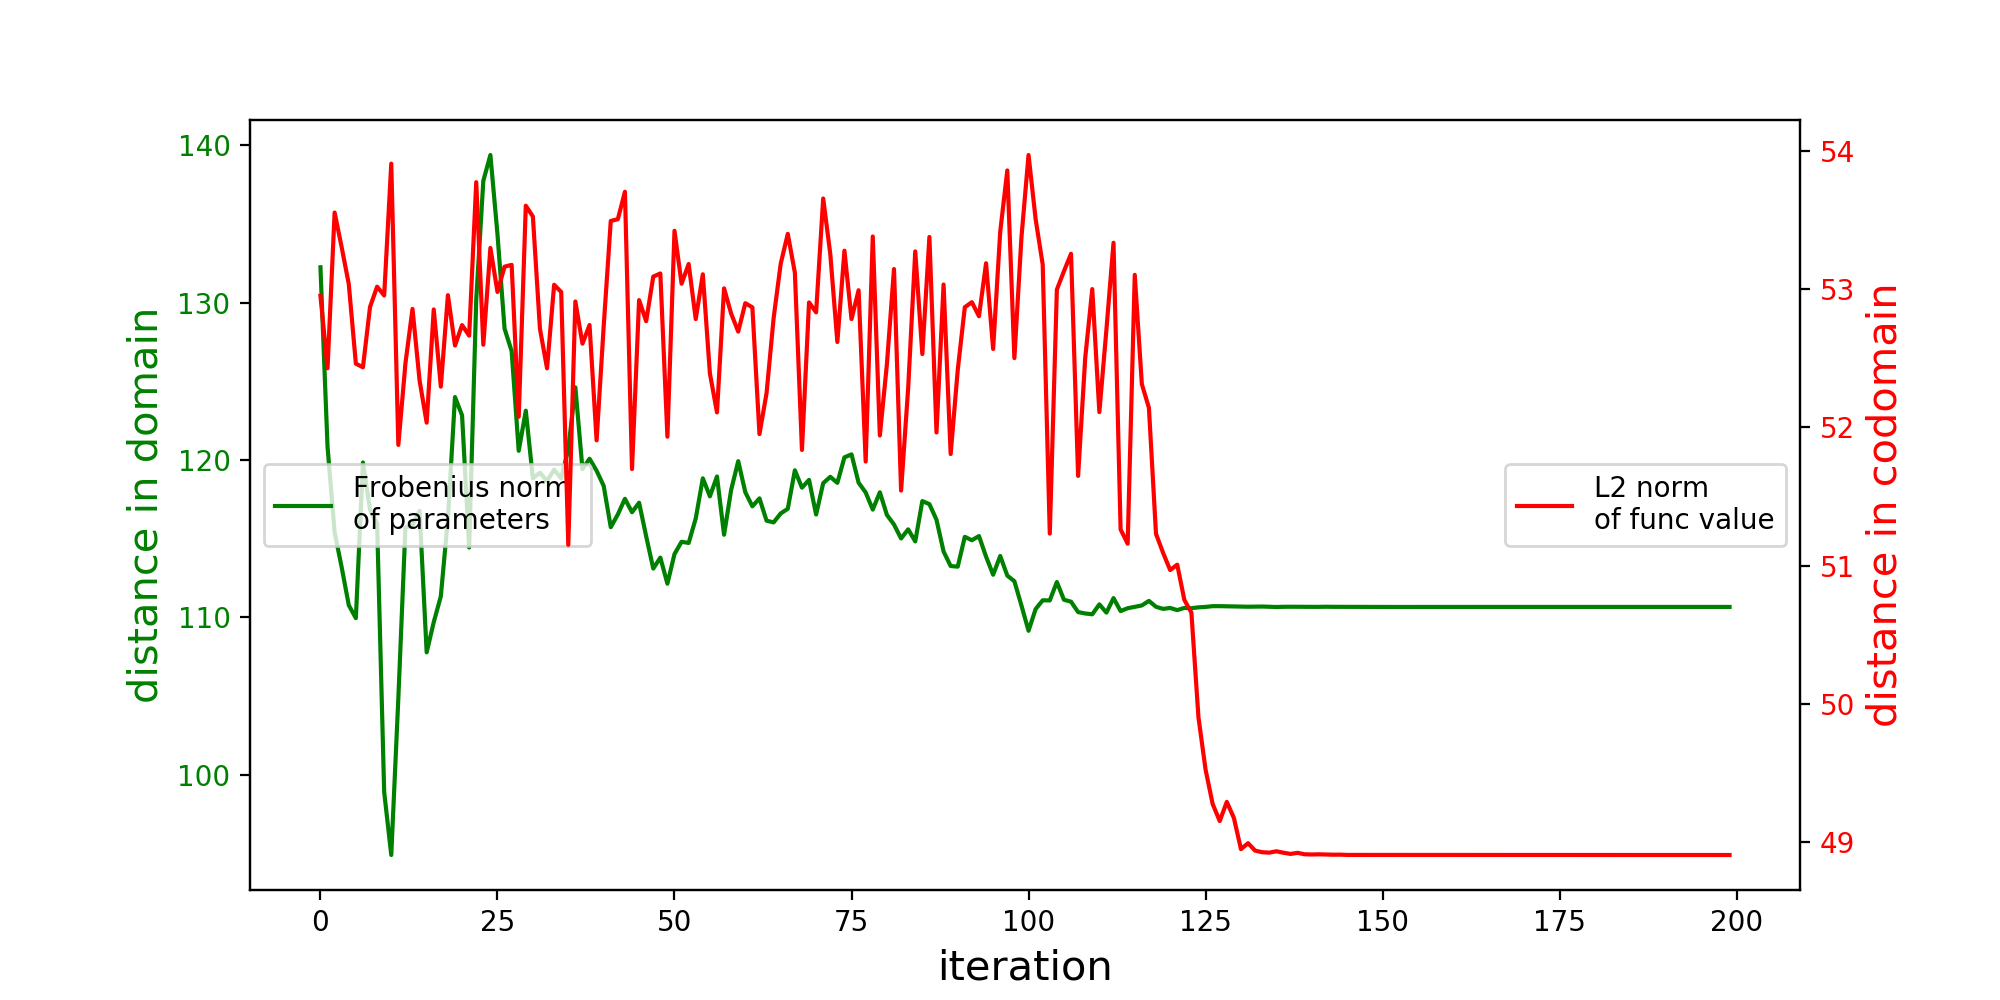

In [243]:
plot_distance(arg, val)

<IPython.core.display.Javascript object>


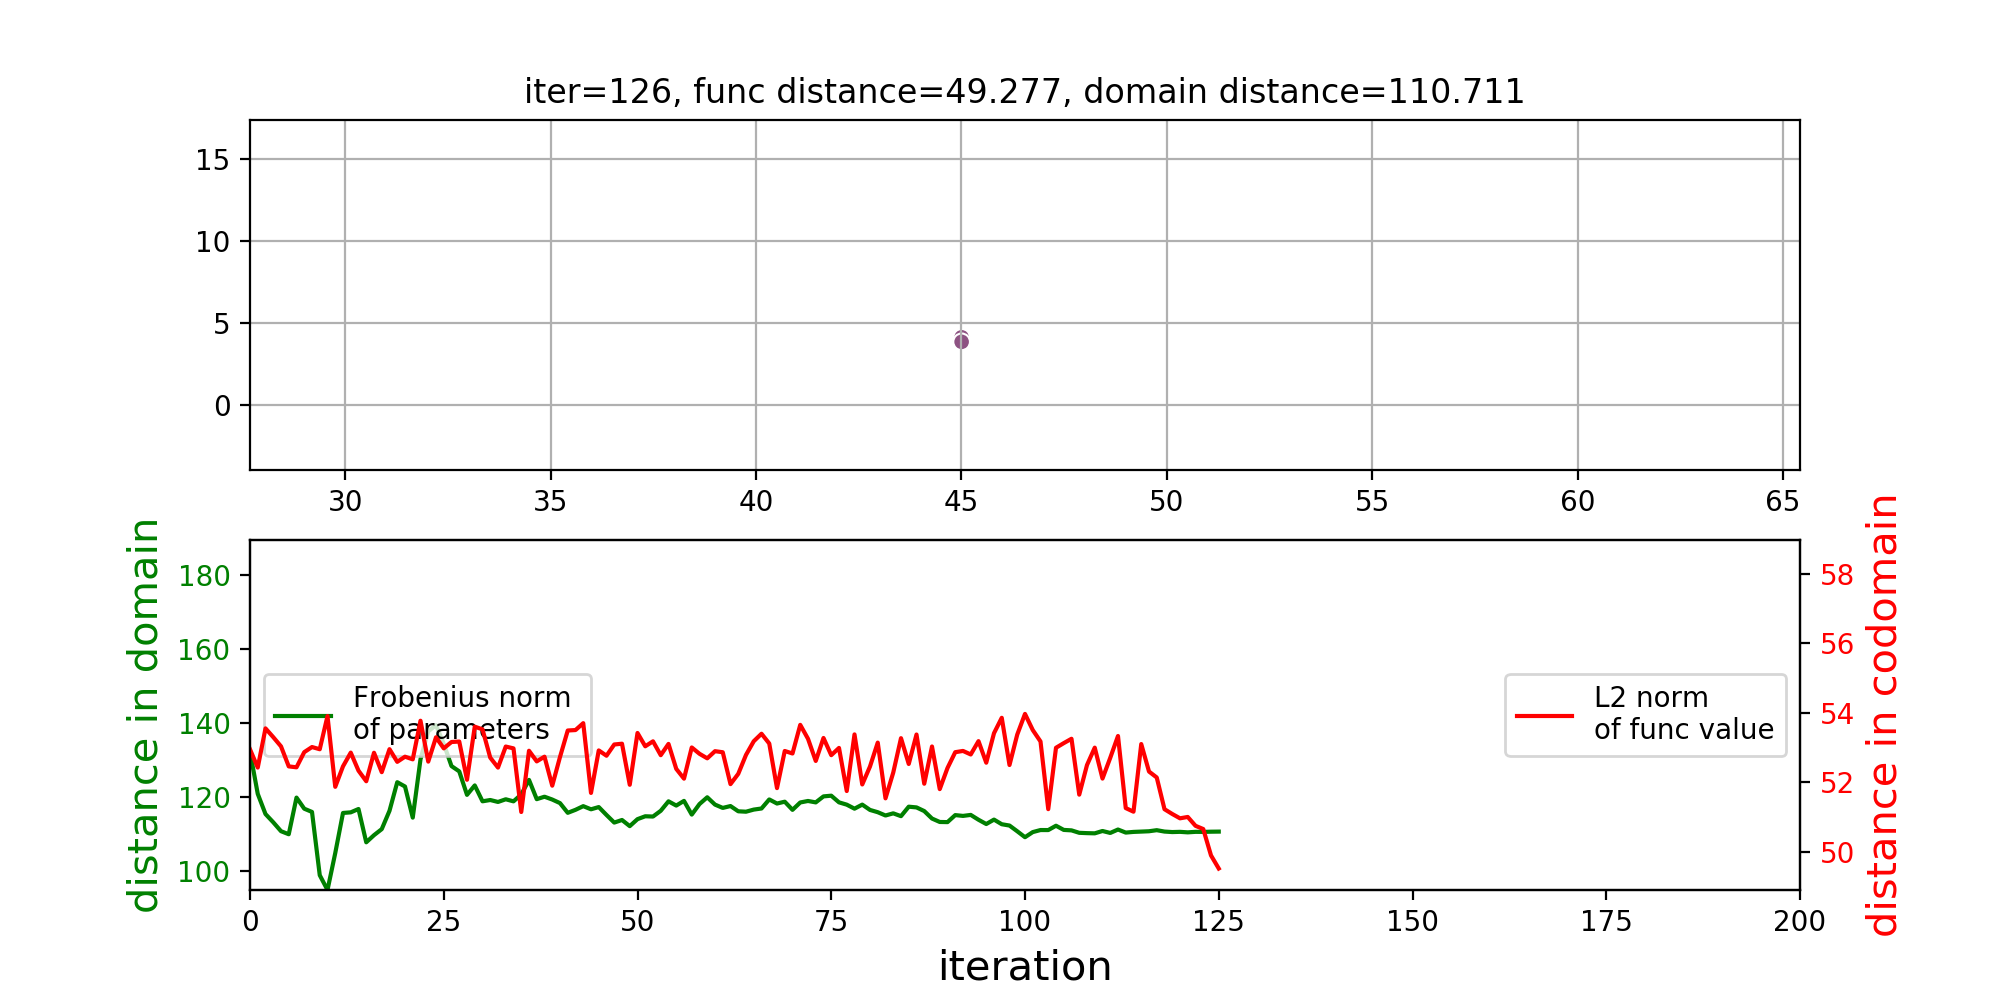

In [21]:
animate_scatterplot_distance(arg, val)

<IPython.core.display.Javascript object>


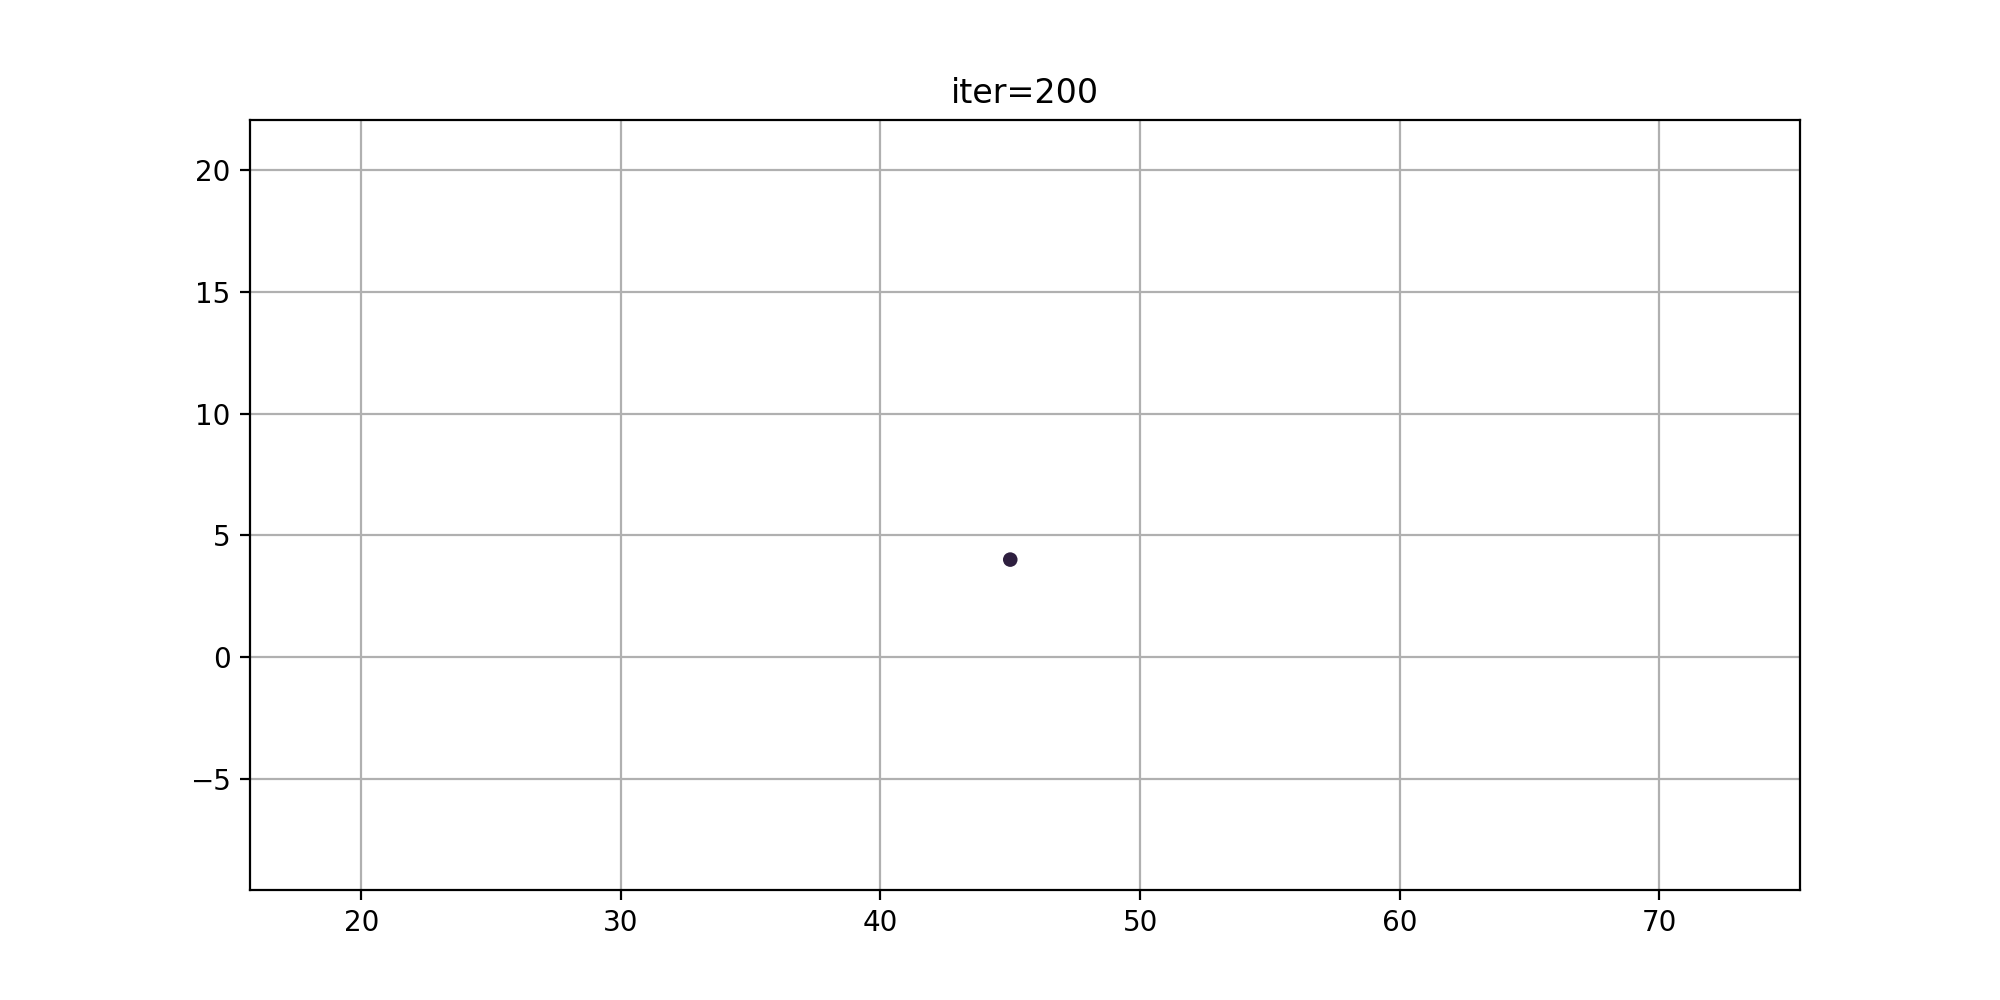

In [19]:
animate_moving_cluster(stats, 100)

In [242]:
print_mean_variance(stats)

iter= 0 mean= [[52.743 12.210]] 
 [[9.000 0.000]
 [0.000 9.000]] 

iter= 1 mean= [[50.459 10.711]] 
 [[8.690 1.024]
 [1.024 7.193]] 

iter= 2 mean= [[47.924 8.264]] 
 [[14.132 2.149]
 [2.149 9.585]] 

iter= 3 mean= [[44.728 10.526]] 
 [[22.466 -1.386]
 [-1.386 11.565]] 

iter= 4 mean= [[43.852 10.870]] 
 [[18.490 -1.851]
 [-1.851 8.530]] 

iter= 5 mean= [[40.736 13.028]] 
 [[22.083 -5.690]
 [-5.690 10.015]] 

iter= 6 mean= [[47.035 10.758]] 
 [[31.030 -8.264]
 [-8.264 10.591]] 

iter= 7 mean= [[46.785 10.353]] 
 [[22.814 -6.059]
 [-6.059 7.956]] 

iter= 8 mean= [[46.778 10.467]] 
 [[12.931 -3.280]
 [-3.280 4.394]] 

iter= 9 mean= [[42.384 12.481]] 
 [[24.598 -8.022]
 [-8.022 7.281]] 

iter= 10 mean= [[37.323 10.650]] 
 [[53.078 -6.638]
 [-6.638 9.594]] 

iter= 11 mean= [[34.887 10.642]] 
 [[59.836 -5.416]
 [-5.416 9.091]] 

iter= 12 mean= [[40.549 9.955]] 
 [[35.202 -3.222]
 [-3.222 4.377]] 

iter= 13 mean= [[43.721 10.539]] 
 [[26.543 -1.717]
 [-1.717 2.784]] 

iter= 14 mean= [[49.589

In [22]:
np.random.seed(34)
mean0 = np.array([[52.743], [12.21]])
sigma = np.ones((2,)) * 3
alpha = 1
beta = 2

%time val, arg, stats = cma_es_general(mean0, sigma, alpha, beta, round_off)

Global minimum
min = 4.440892098500626e-16, total iterations = 29, total evaluatios = 174
 position = -0.0 0.0

CPU times: user 18.6 ms, sys: 2.6 ms, total: 21.2 ms
Wall time: 21.1 ms


<IPython.core.display.Javascript object>


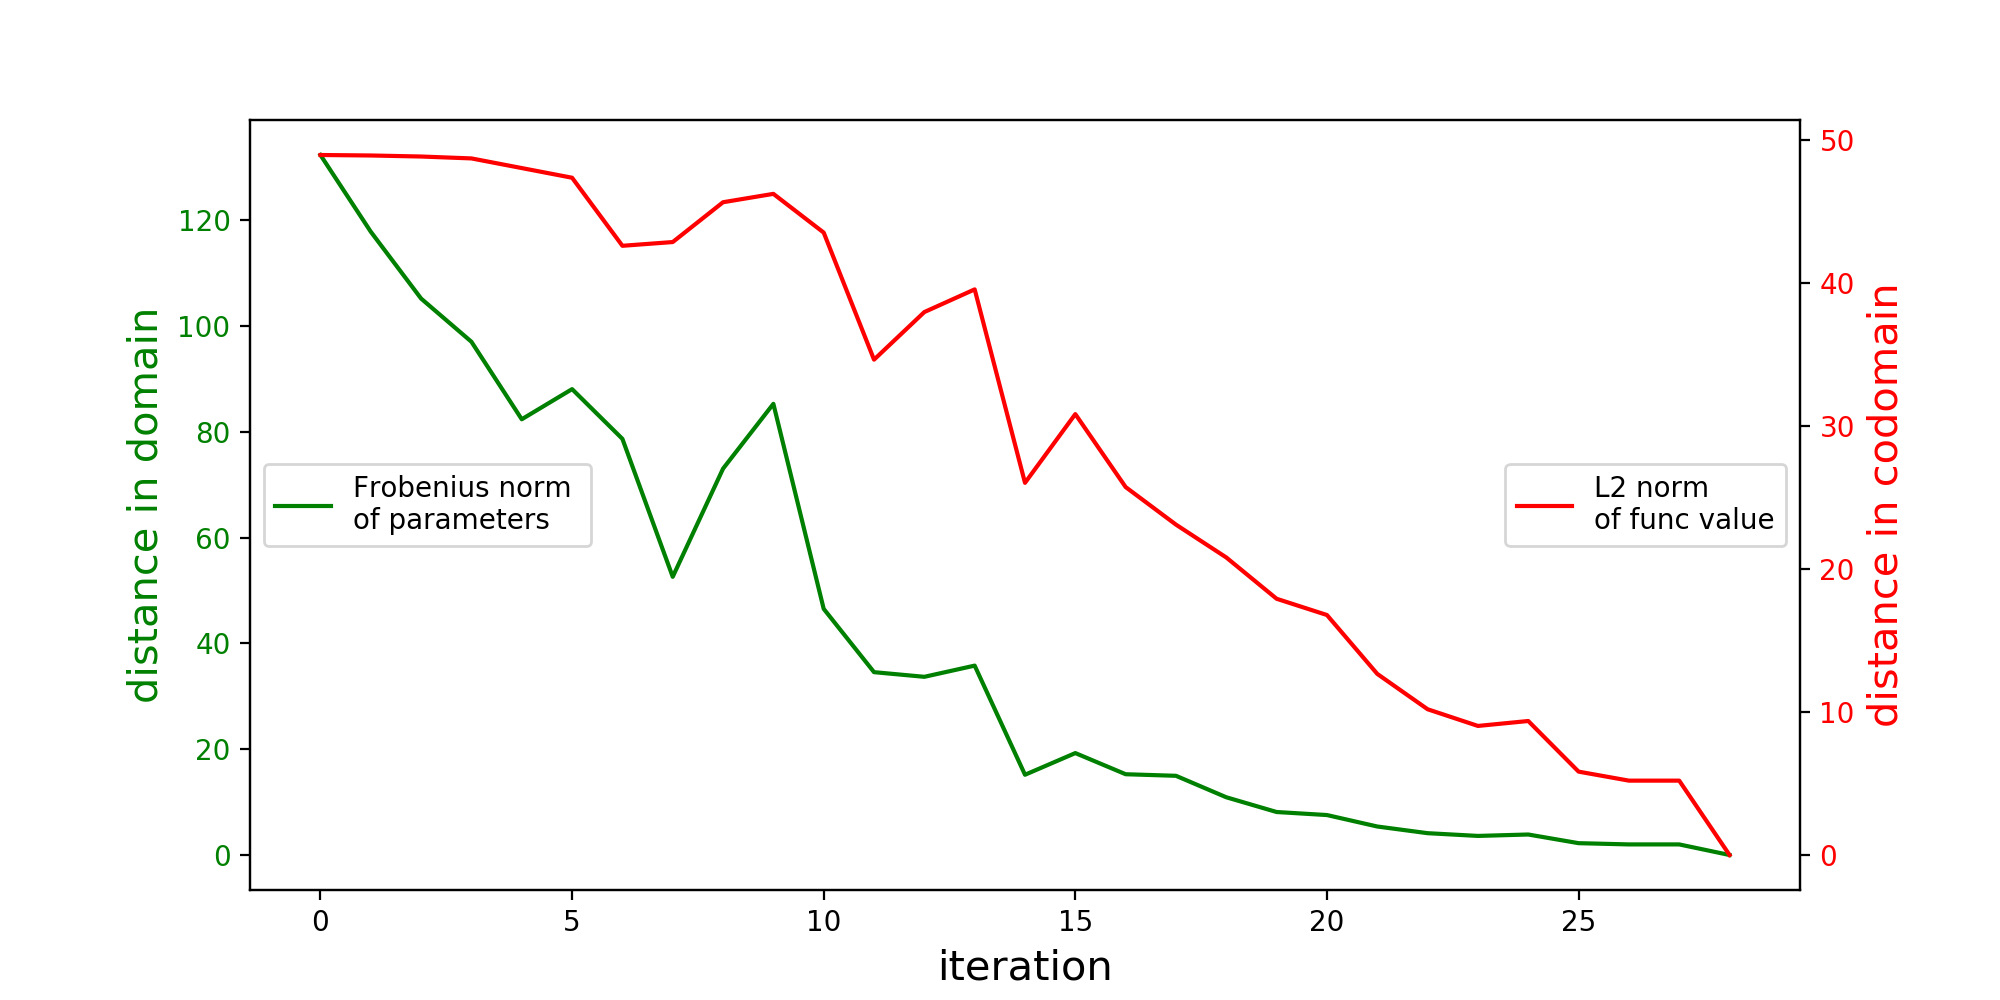

In [23]:
plot_distance(arg, val)

<IPython.core.display.Javascript object>


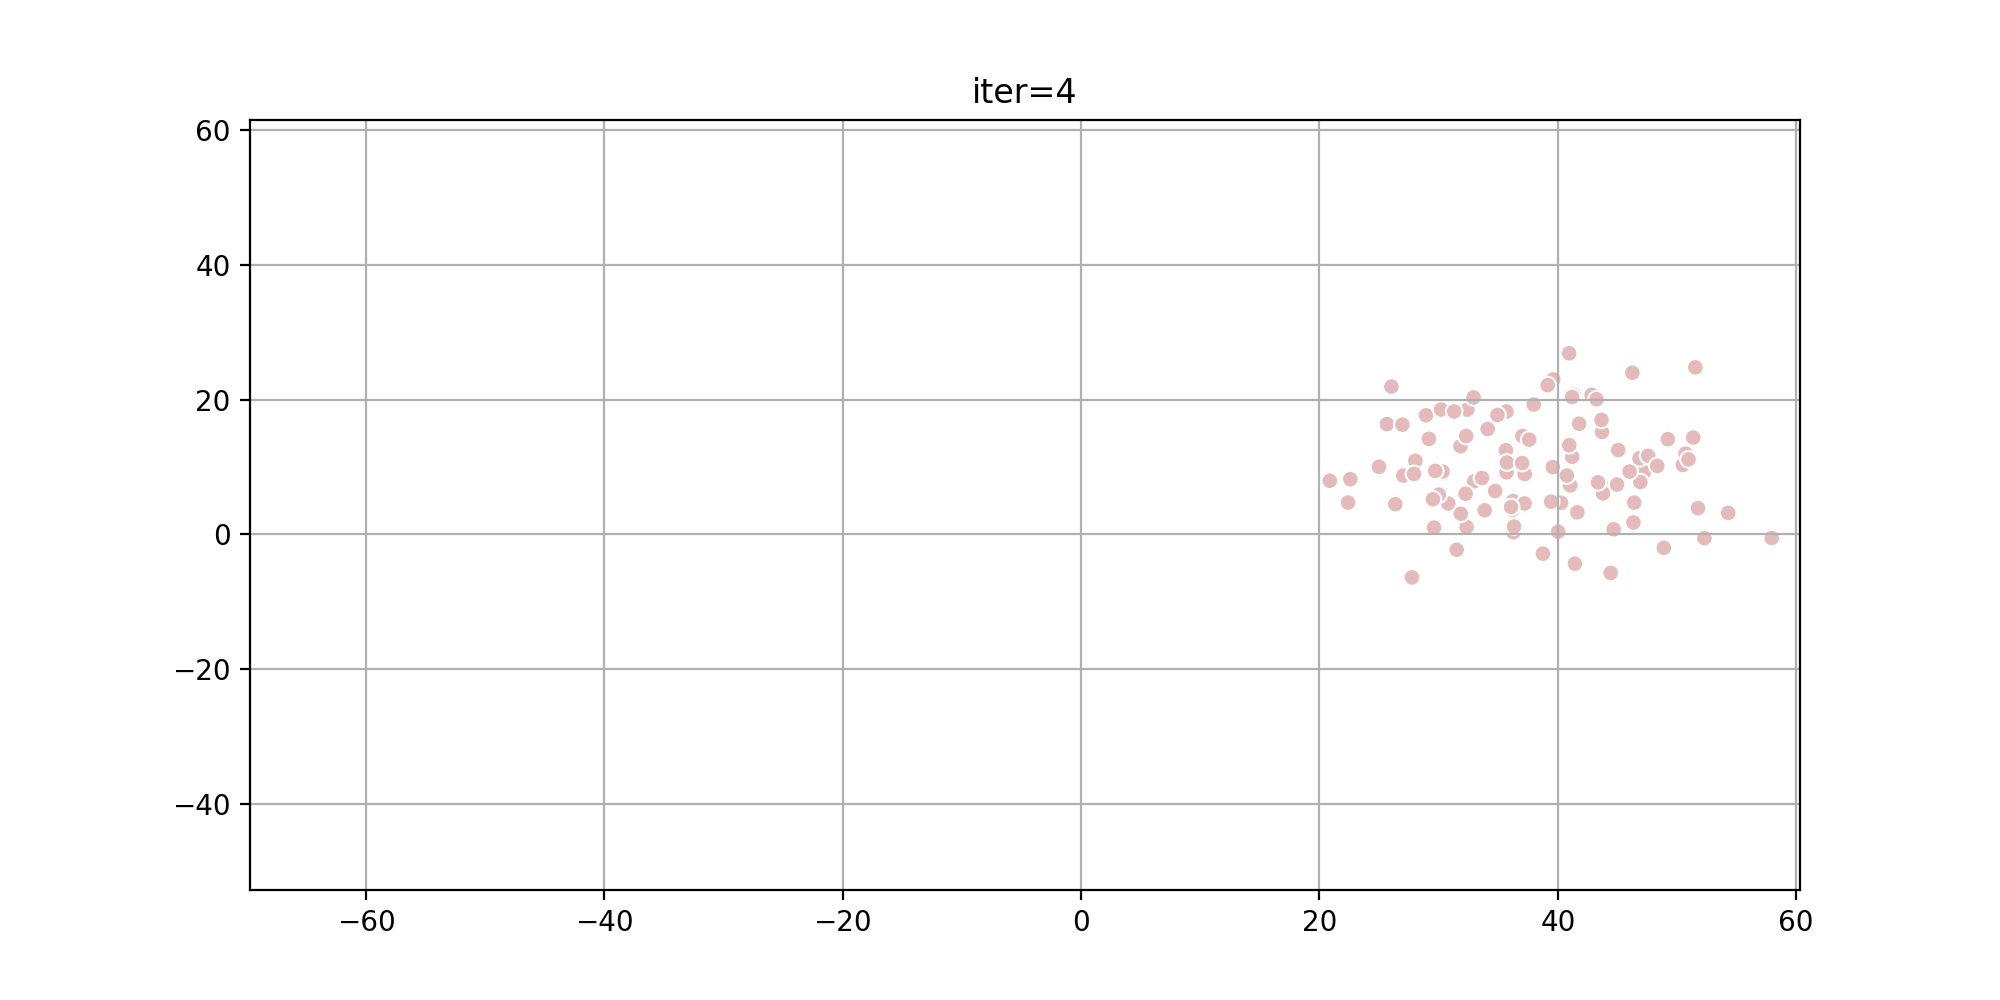

In [16]:
animate_moving_cluster(stats, 100)

In [17]:
print_arguments_before_and_after_move(stats)

iter= 0 
before
 [[53.475 48.059 51.687 53.611 54.177 55.000]
 [9.968 10.817 8.366 15.150 13.562 10.678]] 
after
 [[53.000 48.000 52.000 54.000 54.000 55.000]
 [10.000 11.000 8.000 15.000 14.000 11.000]] 

iter= 1 
before
 [[48.041 46.417 42.030 45.721 51.459 47.834]
 [7.892 14.867 10.085 7.293 6.459 13.624]] 
after
 [[48.000 46.000 42.000 46.000 51.000 48.000]
 [8.000 15.000 10.000 7.000 6.000 14.000]] 

iter= 2 
before
 [[40.849 39.930 49.427 36.788 42.053 37.601]
 [15.895 7.172 5.813 10.993 16.148 9.097]] 
after
 [[41.000 40.000 49.000 37.000 42.000 38.000]
 [16.000 7.000 6.000 11.000 16.000 9.000]] 

iter= 3 
before
 [[43.978 42.332 39.820 32.583 27.894 38.849]
 [14.114 7.018 5.883 15.298 7.812 11.908]] 
after
 [[44.000 42.000 40.000 33.000 28.000 39.000]
 [14.000 7.000 6.000 15.000 8.000 12.000]] 

iter= 4 
before
 [[13.817 45.494 27.554 15.655 35.553 36.789]
 [18.707 9.929 10.175 13.456 10.285 4.782]] 
after
 [[14.000 45.000 28.000 16.000 36.000 37.000]
 [19.000 10.000 10.000 13.

In [250]:
print_mean_variance(stats)

iter= 0 mean= [[52.743 12.210]] 
 [[9.000 0.000]
 [0.000 9.000]] 

iter= 1 mean= [[49.530 10.068]] 
 [[10.308 0.260]
 [0.260 9.885]] 

iter= 2 mean= [[43.452 9.538]] 
 [[25.371 0.700]
 [0.700 22.823]] 

iter= 3 mean= [[37.520 10.117]] 
 [[57.459 1.268]
 [1.268 50.093]] 

iter= 4 mean= [[30.363 9.835]] 
 [[114.724 2.783]
 [2.783 83.621]] 

iter= 5 mean= [[16.372 14.472]] 
 [[256.742 1.790]
 [1.790 166.038]] 

iter= 6 mean= [[-3.301 12.149]] 
 [[621.934 8.248]
 [8.248 327.295]] 

iter= 7 mean= [[-5.373 1.069]] 
 [[724.836 19.612]
 [19.612 437.388]] 

iter= 8 mean= [[-3.675 3.502]] 
 [[508.459 14.772]
 [14.772 308.960]] 

iter= 9 mean= [[-10.112 -0.009]] 
 [[363.270 15.494]
 [15.494 220.887]] 

iter= 10 mean= [[-10.419 -2.563]] 
 [[216.721 8.831]
 [8.831 136.758]] 

iter= 11 mean= [[-3.189 0.407]] 
 [[120.387 10.106]
 [10.106 72.475]] 

iter= 12 mean= [[1.371 -0.128]] 
 [[81.008 5.846]
 [5.846 42.733]] 

iter= 13 mean= [[1.345 3.342]] 
 [[52.197 4.579]
 [4.579 29.972]] 

iter= 14 mean= [[

In [31]:
np.random.seed(34)
mean0 = np.array([[52.743], [12.21]])
sigma = np.ones((2,)) * 3
alpha = 1
beta = 2

%time val, arg, stats = cma_es_general(mean0, sigma, alpha, beta, line_search)

Global minimum
min = 4.440892098500626e-16, total iterations = 24, total evaluatios = 16706
 position = 2.414947726522687e-17 1.9903473413229305e-17

CPU times: user 318 ms, sys: 5.46 ms, total: 323 ms
Wall time: 332 ms


In [32]:
print_arguments_before_and_after_move(stats)

iter= 0 
before
 [[53.475 48.059 51.687 53.611 54.177 55.000]
 [9.968 10.817 8.366 15.150 13.562 10.678]] 
after
 [[53.000 48.000 53.000 54.000 53.000 55.000]
 [11.000 11.000 7.000 15.000 14.000 11.000]] 

iter= 1 
before
 [[52.351 46.230 52.153 53.648 52.640 46.966]
 [9.261 5.215 2.855 7.312 12.972 6.988]] 
after
 [[52.000 46.000 52.000 54.000 53.000 47.000]
 [9.000 5.000 3.000 7.000 13.000 7.000]] 

iter= 2 
before
 [[46.847 50.141 43.311 51.398 45.854 51.343]
 [-2.336 6.727 11.509 1.519 -2.188 3.842]] 
after
 [[48.000 50.000 44.000 52.000 46.000 50.000]
 [-1.000 7.000 13.000 3.000 -2.000 5.000]] 

iter= 3 
before
 [[40.576 42.532 44.149 47.010 50.786 43.859]
 [5.432 11.005 11.515 2.525 7.904 6.383]] 
after
 [[41.000 43.000 42.000 47.000 51.000 44.000]
 [5.000 11.000 12.000 3.000 8.000 6.000]] 

iter= 4 
before
 [[48.177 33.996 42.768 48.097 38.822 39.078]
 [-0.868 9.564 6.832 2.924 7.902 11.778]] 
after
 [[48.000 34.000 43.000 48.000 39.000 39.000]
 [-1.000 11.000 7.000 3.000 8.000 

In [299]:
print_evaluations_per_iteration(stats)

iter= 0 
 [79.000 69.000 77.000 71.000 77.000 75.000] 

iter= 1 
 [79.000 69.000 67.000 75.000 75.000 71.000] 

iter= 2 
 [71.000 75.000 79.000 81.000 75.000 75.000] 

iter= 3 
 [73.000 71.000 79.000 75.000 77.000 67.000] 

iter= 4 
 [73.000 73.000 77.000 75.000 69.000 77.000] 

iter= 5 
 [71.000 79.000 75.000 77.000 71.000 73.000] 

iter= 6 
 [77.000 71.000 77.000 81.000 79.000 77.000] 

iter= 7 
 [77.000 73.000 81.000 79.000 79.000 75.000] 

iter= 8 
 [73.000 73.000 73.000 73.000 91.000 73.000] 

iter= 9 
 [77.000 73.000 73.000 73.000 69.000 75.000] 

iter= 10 
 [77.000 75.000 77.000 73.000 73.000 77.000] 

iter= 11 
 [73.000 69.000 309.000 77.000 75.000 75.000] 

iter= 12 
 [77.000 75.000 75.000 77.000 75.000 77.000] 

iter= 13 
 [73.000 73.000 81.000 75.000 95.000 75.000] 

iter= 14 
 [305.000 309.000 77.000 77.000 71.000 67.000] 

iter= 15 
 [73.000 77.000 71.000 71.000 77.000 71.000] 

iter= 16 
 [71.000 309.000 93.000 65.000 79.000 309.000] 

iter= 17 
 [75.000 57.000 93.000 73.

In [296]:
stats['evals_per_iter'].shape

(24, 1, 6)

In [294]:
print_arguments_before_and_after_move(stats)

iter= 0 
before
 [[53.475 48.059 51.687 53.611 54.177 55.000]
 [9.968 10.817 8.366 15.150 13.562 10.678]] 
after
 [[53.000 48.000 53.000 54.000 53.000 55.000]
 [11.000 11.000 7.000 15.000 14.000 11.000]] 

iter= 1 
before
 [[52.351 46.230 52.153 53.648 52.640 46.966]
 [9.261 5.215 2.855 7.312 12.972 6.988]] 
after
 [[52.000 46.000 52.000 54.000 53.000 47.000]
 [9.000 5.000 3.000 7.000 13.000 7.000]] 

iter= 2 
before
 [[46.847 50.141 43.311 51.398 45.854 51.343]
 [-2.336 6.727 11.509 1.519 -2.188 3.842]] 
after
 [[48.000 50.000 44.000 52.000 46.000 50.000]
 [-1.000 7.000 13.000 3.000 -2.000 5.000]] 

iter= 3 
before
 [[40.576 42.532 44.149 47.010 50.786 43.859]
 [5.432 11.005 11.515 2.525 7.904 6.383]] 
after
 [[41.000 43.000 42.000 47.000 51.000 44.000]
 [5.000 11.000 12.000 3.000 8.000 6.000]] 

iter= 4 
before
 [[48.177 33.996 42.768 48.097 38.822 39.078]
 [-0.868 9.564 6.832 2.924 7.902 11.778]] 
after
 [[48.000 34.000 43.000 48.000 39.000 39.000]
 [-1.000 11.000 7.000 3.000 8.000 

## Ex2
setup:
    invariable: 
        - seed = 34
        - (cma-es)mean = [140.743, 152.21] 
        - variance = [9, 9]
        - (line search) alpha = 1
        - beta = 2
    variable:
        - line_search vs do_nothing vs round_off

### do_nothing

In [42]:
np.random.seed(34)
mean0 = np.array([[140.743], [152.21]])
sigma = np.ones((2,)) * 3
alpha = 1
beta = 2
%time val, arg, stats = cma_es_general(mean0, sigma, alpha, beta, do_nothing)

stuck in local minimum or diverge!!
iterations = 200, eigenvalue = [0.898 0.076]
min = 20.655754117133586, total iterations = 200, total evaluatios = 1200
 position = -1556155.8731582821 280371.8847298474

CPU times: user 107 ms, sys: 3.7 ms, total: 111 ms
Wall time: 136 ms


<IPython.core.display.Javascript object>


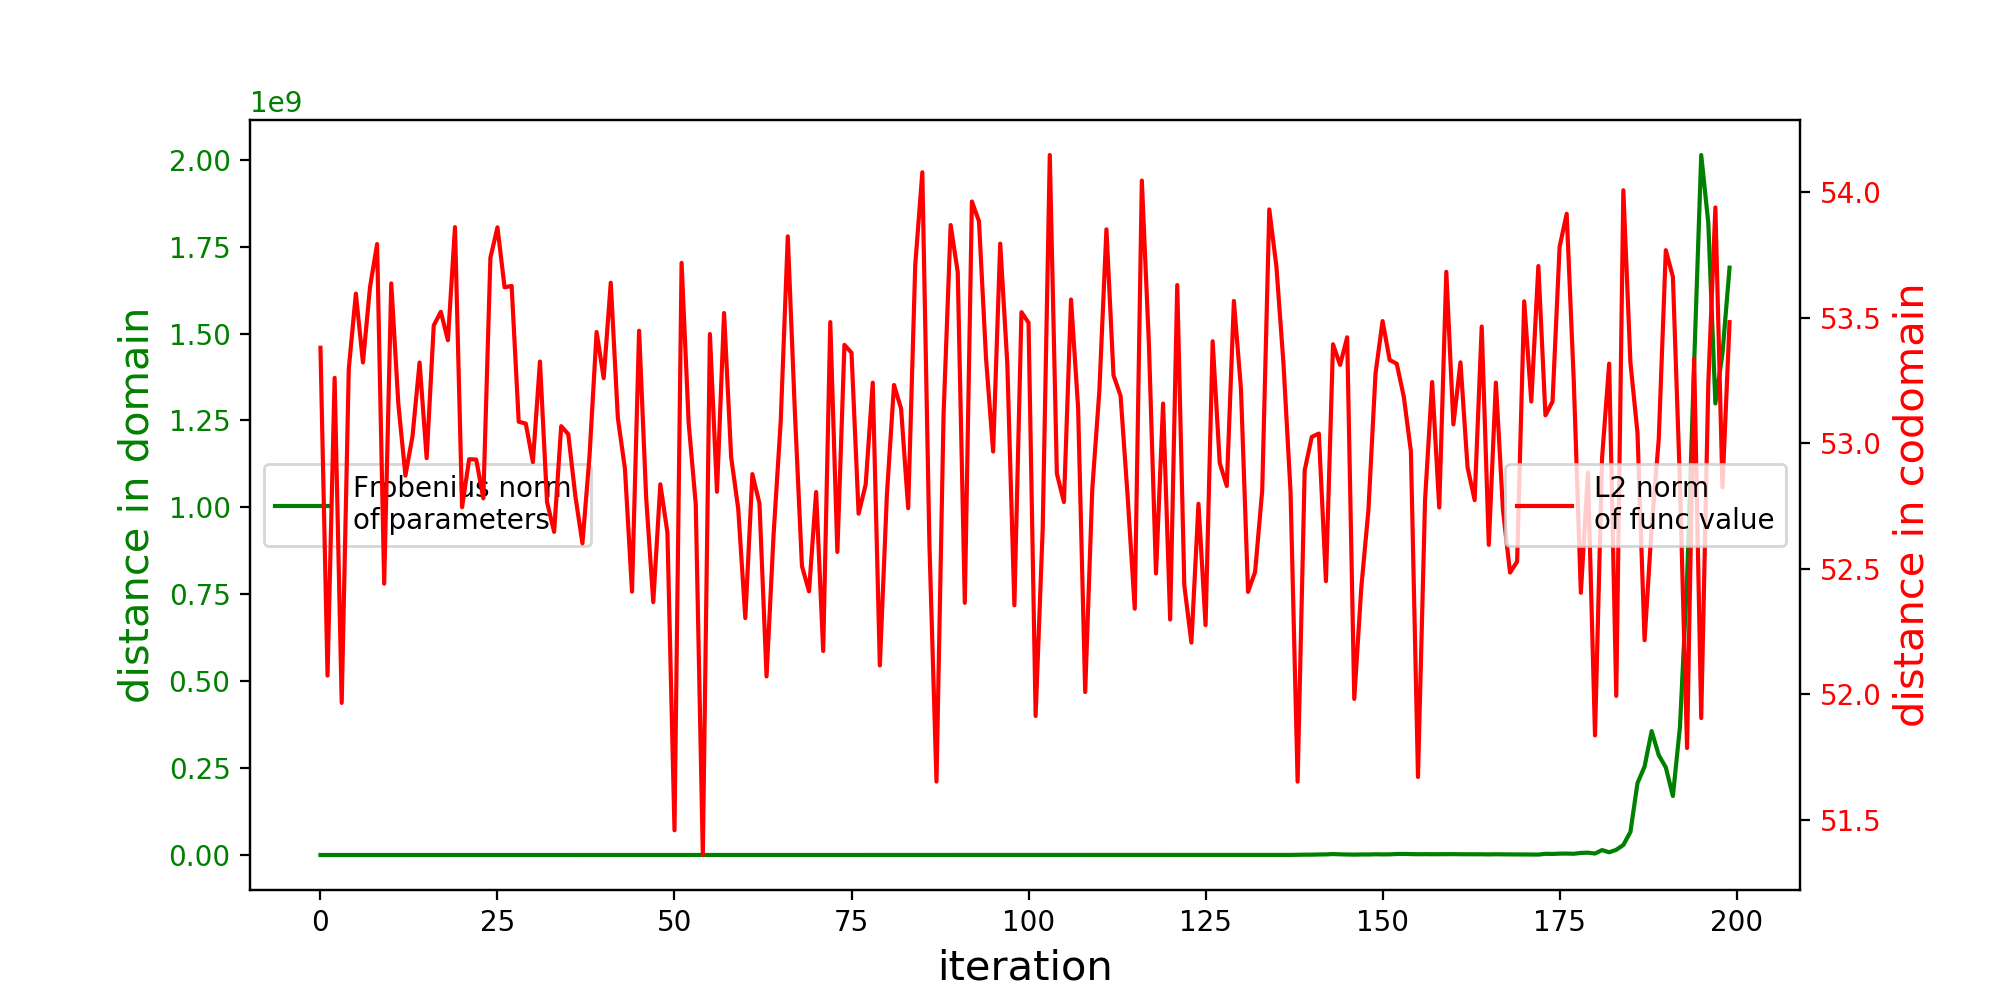

In [39]:
plot_distance(arg,val)

<IPython.core.display.Javascript object>


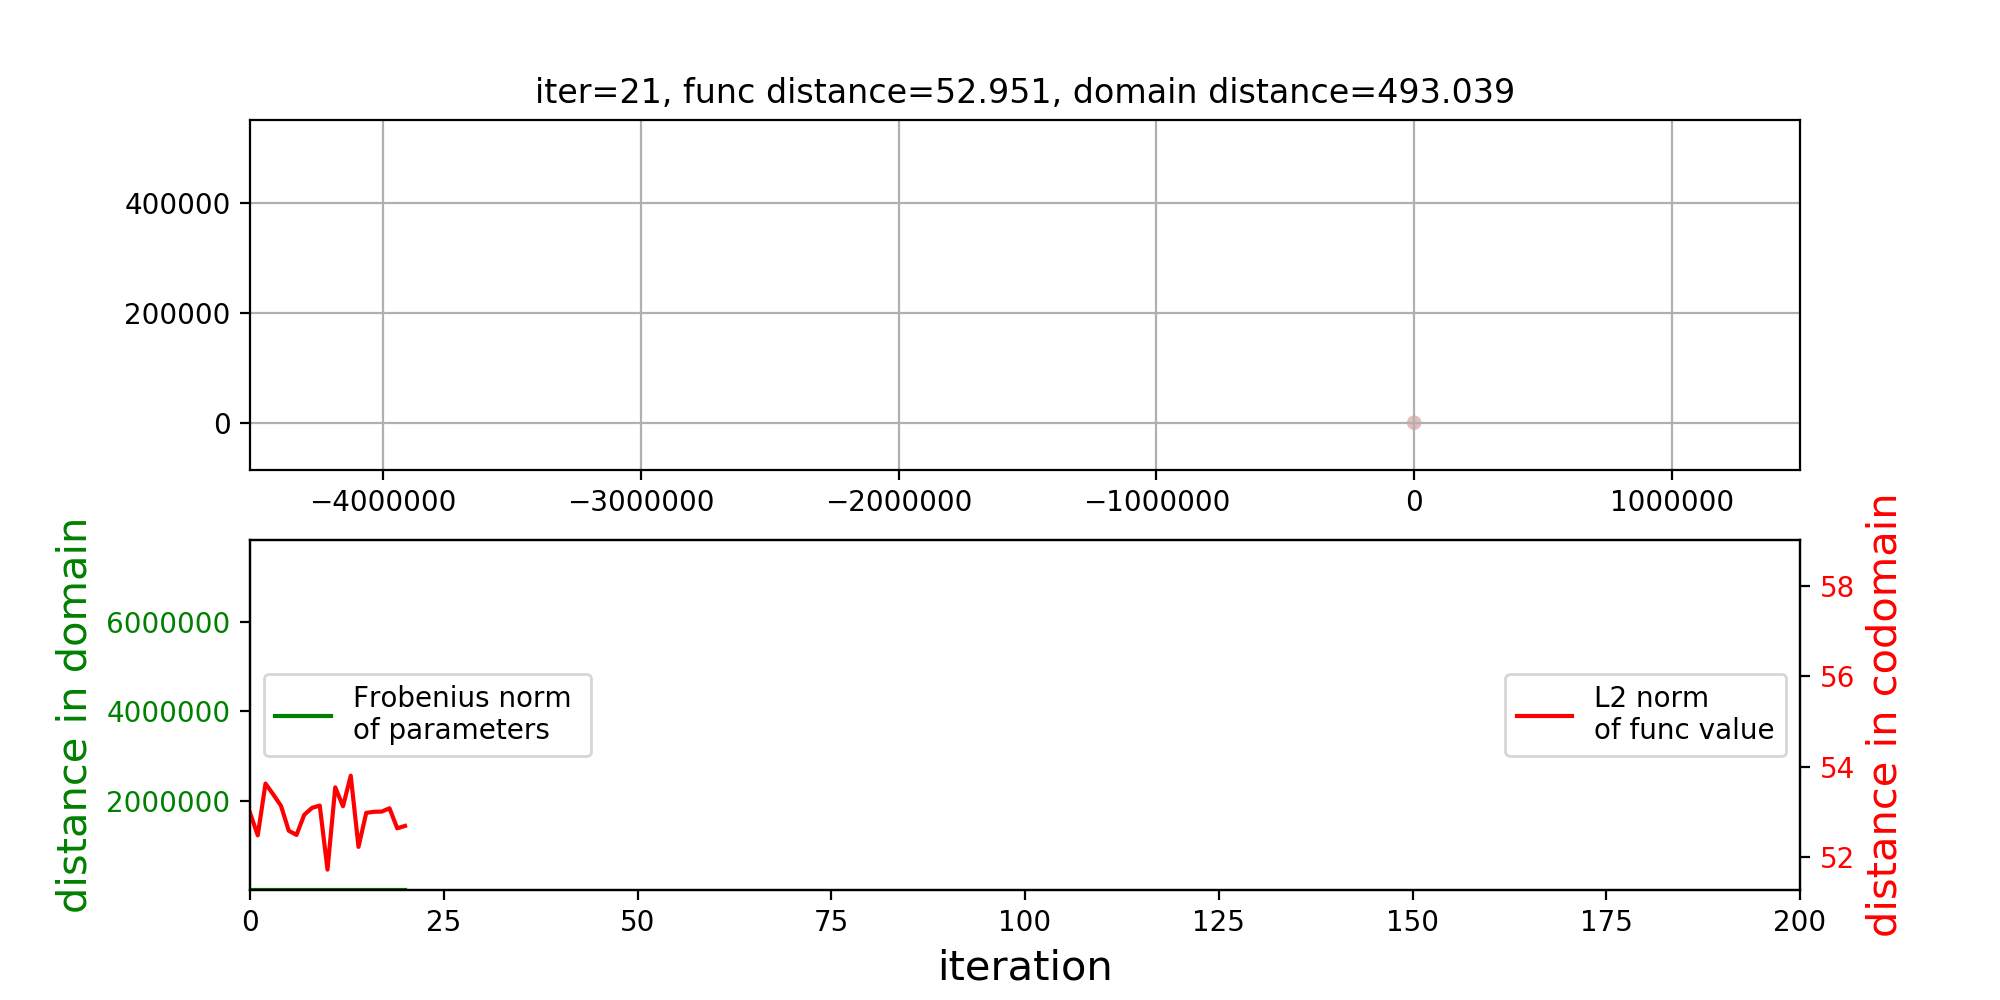

In [44]:
ani = animate_scatterplot_distance(arg, val)

### line search

In [46]:
np.random.seed(34)
mean0 = np.array([[140.743], [152.21]])
sigma = np.ones((2,)) * 3
alpha = 1
beta = 2

%time val, arg, stats = cma_es_general(mean0, sigma, alpha, beta, line_search)

Global minimum
min = 4.440892098500626e-16, total iterations = 37, total evaluatios = 22460
 position = 1.0529642920474356e-16 1.179580288606663e-16

CPU times: user 443 ms, sys: 6.08 ms, total: 449 ms
Wall time: 494 ms


<IPython.core.display.Javascript object>


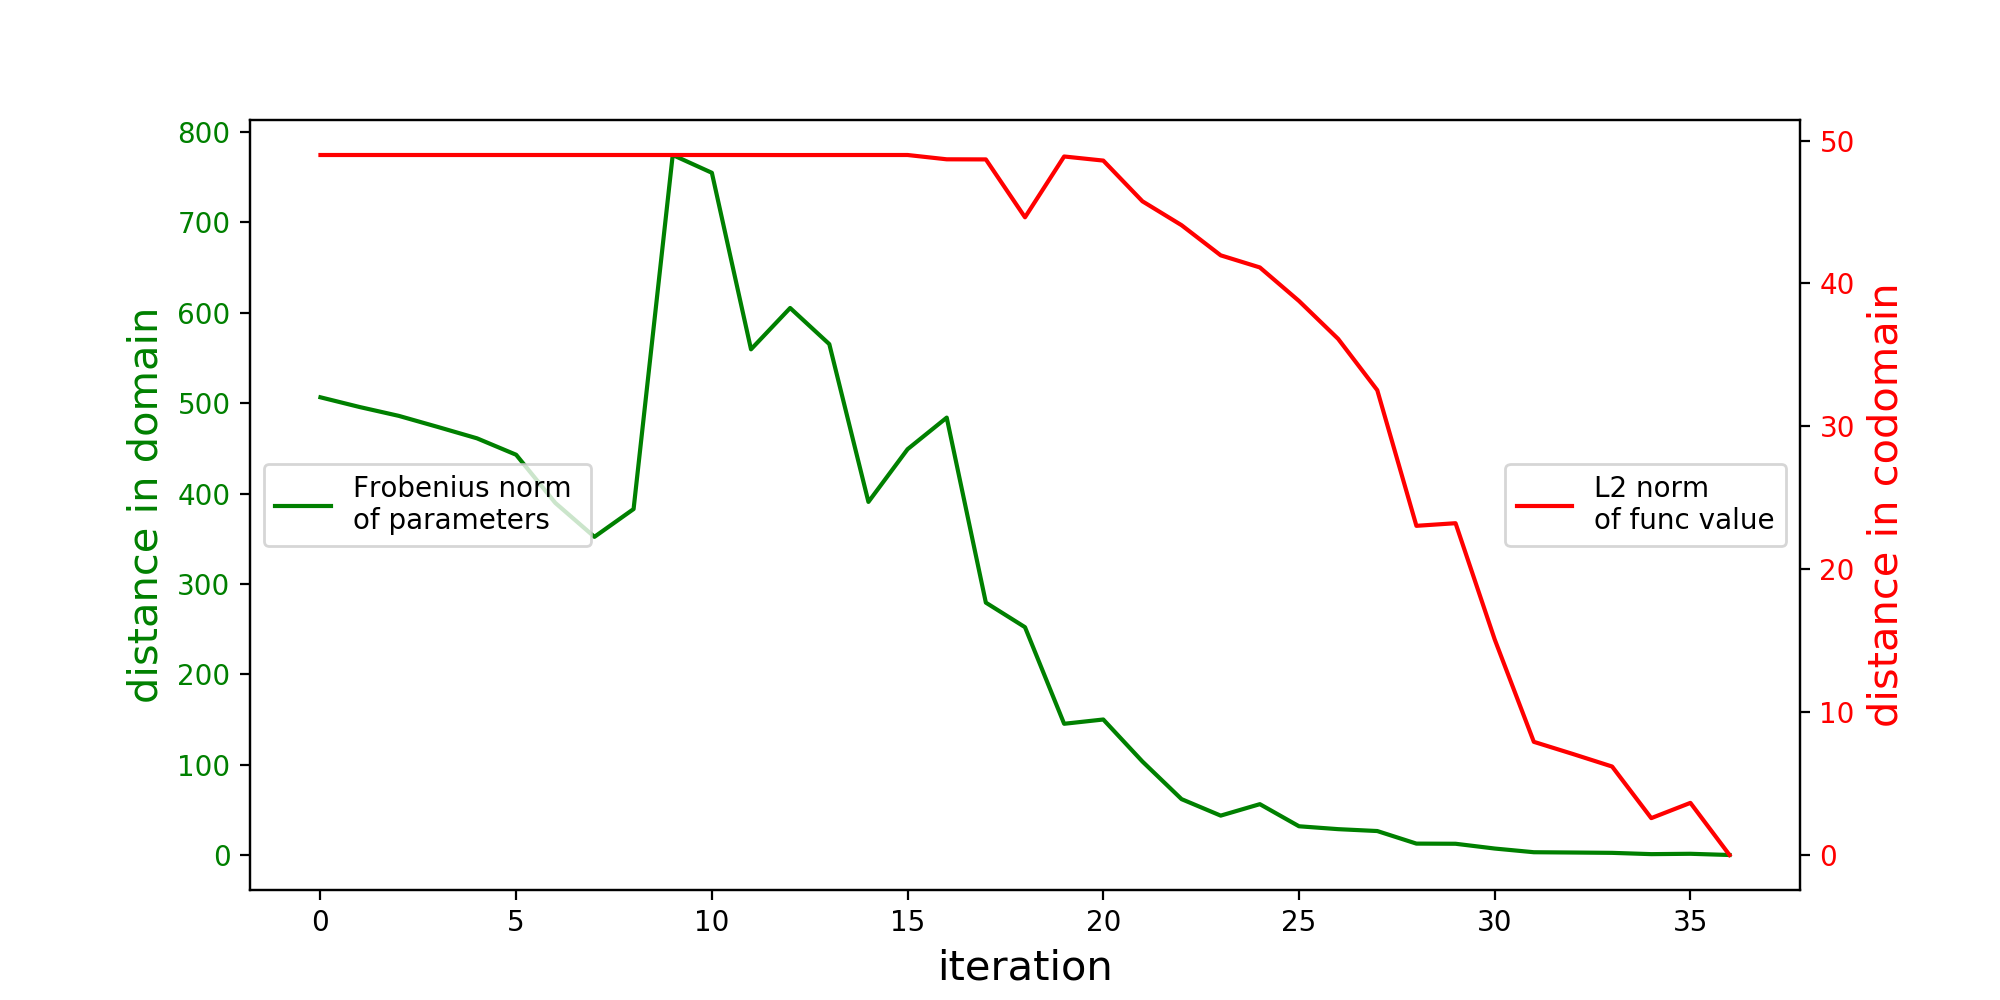

In [47]:
plot_distance(arg, val)

<IPython.core.display.Javascript object>


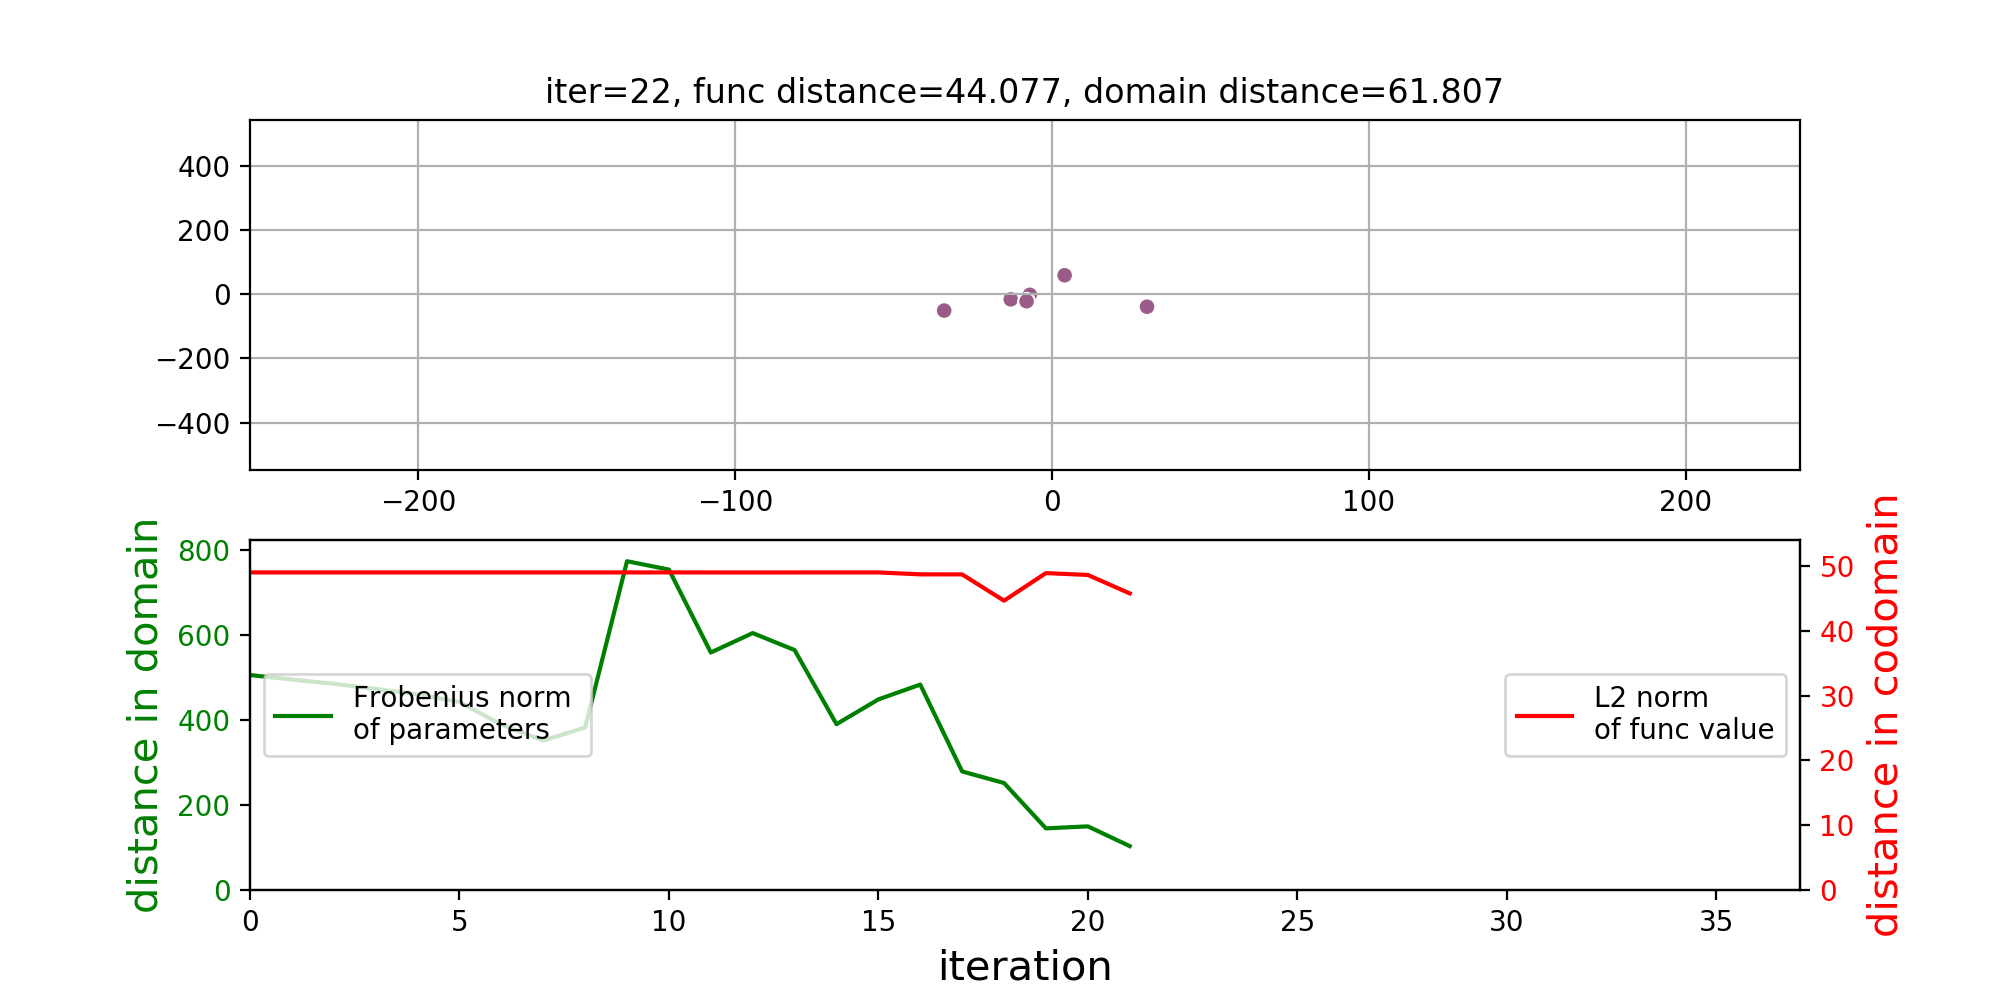

In [50]:
ani = animate_scatterplot_distance(arg, val)

In [137]:
stats['x_vs_original'][:15]

array([[[141.475, 136.059, 139.687, 141.611, 142.177, 143.000],
        [149.968, 150.817, 148.366, 155.150, 153.562, 150.678],
        [1.000, 1.000, 1.000, 1.000, 1.000, 1.000],
        [141.000, 136.000, 140.000, 142.000, 142.000, 143.000],
        [150.000, 151.000, 148.000, 155.000, 154.000, 151.000]],

       [[136.041, 134.417, 130.030, 133.721, 139.459, 135.834],
        [147.892, 154.867, 150.085, 147.293, 146.459, 153.624],
        [2.000, 2.000, 2.000, 2.000, 2.000, 2.000],
        [136.000, 134.000, 130.000, 134.000, 139.000, 136.000],
        [148.000, 155.000, 150.000, 147.000, 146.000, 154.000]],

       [[128.914, 128.173, 137.586, 124.994, 130.100, 125.833],
        [155.197, 146.585, 145.445, 150.282, 155.471, 148.432],
        [3.000, 3.000, 3.000, 3.000, 3.000, 3.000],
        [129.000, 128.000, 138.000, 125.000, 130.000, 126.000],
        [155.000, 147.000, 145.000, 150.000, 155.000, 148.000]],

       [[132.338, 131.392, 129.079, 121.284, 117.449, 127.607],
      

### round off

In [24]:
np.random.seed(34)
mean0 = np.array([[140.743], [152.21]])
sigma = np.ones((2,)) * 3
alpha = 1
beta = 2
%time val, arg, stats = cma_es_general(mean0, sigma, alpha, beta, round_off)

Global minimum
min = 4.440892098500626e-16, total iterations = 44, total evaluatios = 264
 position = -0.0 0.0

CPU times: user 25.1 ms, sys: 2.83 ms, total: 27.9 ms
Wall time: 29.3 ms


<IPython.core.display.Javascript object>


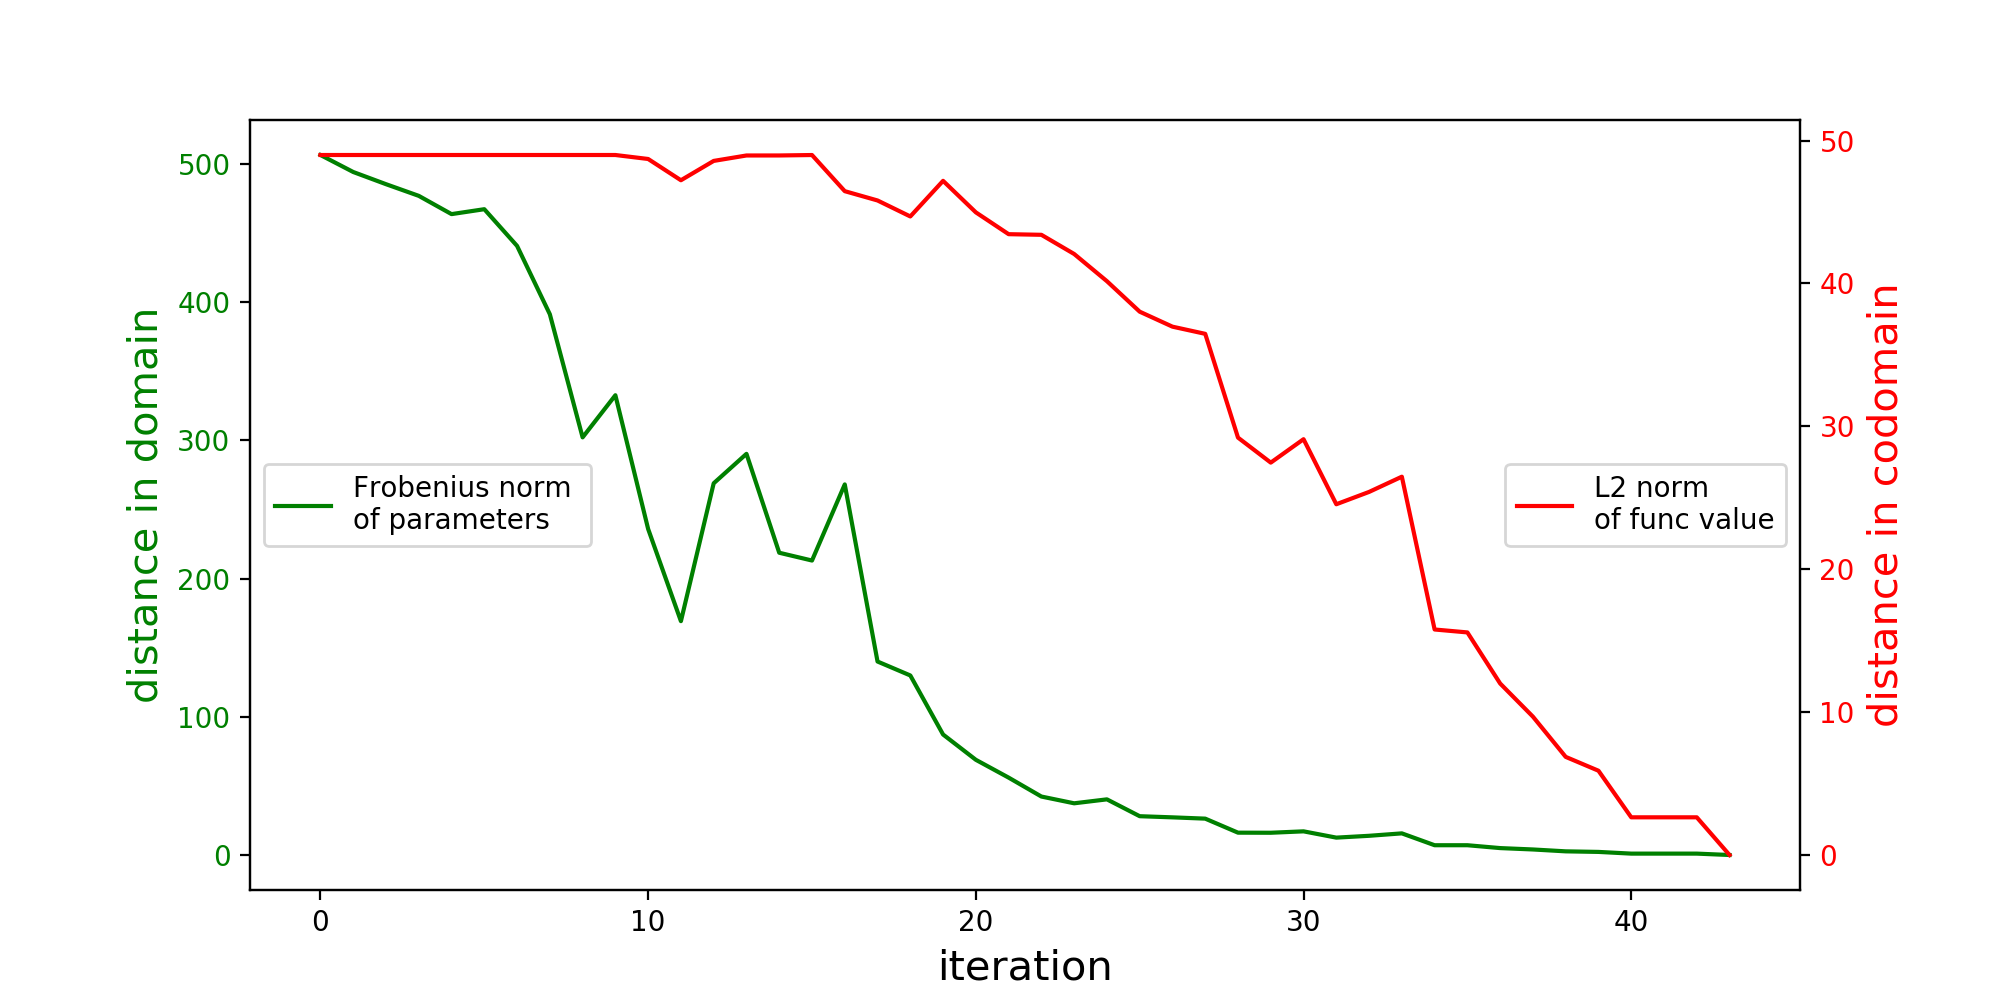

In [25]:
plot_distance(arg,val)

In [26]:
print_mean_variance(stats)

iter= 0 mean= [[140.743 152.210]] 
 [[9.000 0.000]
 [0.000 9.000]] 

iter= 1 mean= [[137.530 150.068]] 
 [[10.308 0.260]
 [0.260 9.885]] 

iter= 2 mean= [[131.609 148.990]] 
 [[24.770 0.779]
 [0.779 22.188]] 

iter= 3 mean= [[126.491 147.872]] 
 [[53.216 1.917]
 [1.917 46.517]] 

iter= 4 mean= [[120.728 145.264]] 
 [[105.558 4.644]
 [4.644 86.531]] 

iter= 5 mean= [[106.372 148.266]] 
 [[246.519 1.702]
 [1.702 165.861]] 

iter= 6 mean= [[87.258 146.149]] 
 [[582.539 8.104]
 [8.104 317.954]] 

iter= 7 mean= [[84.990 135.069]] 
 [[715.256 26.734]
 [26.734 450.566]] 

iter= 8 mean= [[77.742 111.678]] 
 [[1002.248 161.335]
 [161.335 1020.447]] 

iter= 9 mean= [[59.441 74.428]] 
 [[1439.620 694.587]
 [694.587 2375.704]] 

iter= 10 mean= [[66.712 38.551]] 
 [[1643.893 840.677]
 [840.677 4170.550]] 

iter= 11 mean= [[39.117 -3.542]] 
 [[2802.639 2201.983]
 [2201.983 8315.294]] 

iter= 12 mean= [[16.728 9.789]] 
 [[3149.503 2340.527]
 [2340.527 8079.855]] 

iter= 13 mean= [[-19.799 13.533]] 
 

<IPython.core.display.Javascript object>


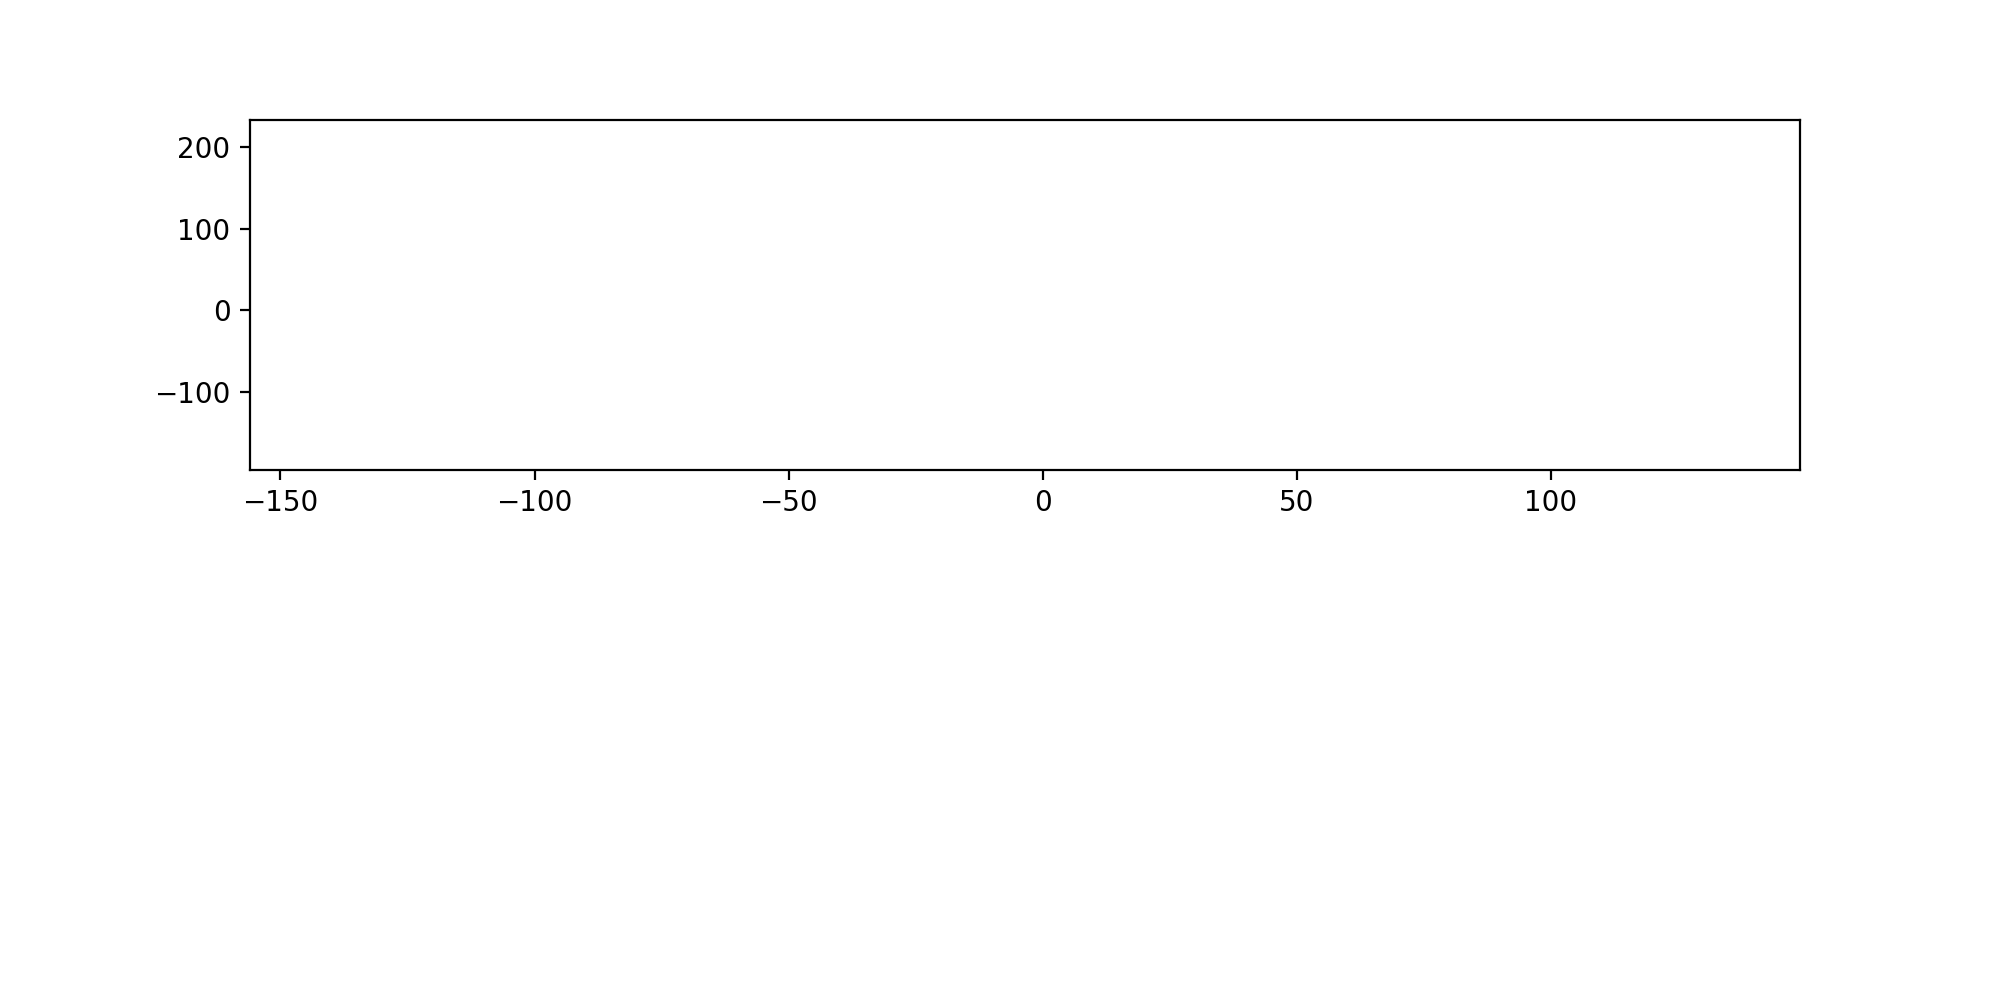

In [30]:
ani = animate_scatterplot_distance(arg, val)

## Ex3
setup:
    invariable: 
        - seed = 34
        - (cma-es)mean = [629.193, 822.221] 
        - variance = [9, 9]
        - (line search) alpha = 1
        - beta = 2
    variable:
        - line_search vs do_nothing vs round_off

In [52]:
np.random.seed(34)
mean0 = np.array([[629.193], [822.221]])
sigma = np.ones((2,)) * 50
alpha = 1
beta = 2

%time val, arg, stats = cma_es_general(mean0, sigma, alpha, beta, do_nothing)

stuck in local minimum or diverge!!
iterations = 200, eigenvalue = [43.252 0.130]
min = 22.02208882711845, total iterations = 200, total evaluatios = 1200
 position = -252755944.9978216 64028.741401069004

CPU times: user 112 ms, sys: 2.86 ms, total: 115 ms
Wall time: 146 ms


In [54]:
np.random.seed(34)
mean0 = np.array([[629.193], [822.221]])
sigma = np.ones((2,)) * 40
alpha = 1
beta = 2

%time val, arg, stats = cma_es_general(mean0, sigma, alpha, beta, line_search)

Global minimum
min = 3.9968028886505635e-15, total iterations = 83, total evaluatios = 43808
 position = 1.608719277937401e-16 -2.8525547556757744e-16

CPU times: user 895 ms, sys: 12.1 ms, total: 907 ms
Wall time: 1.03 s


<IPython.core.display.Javascript object>


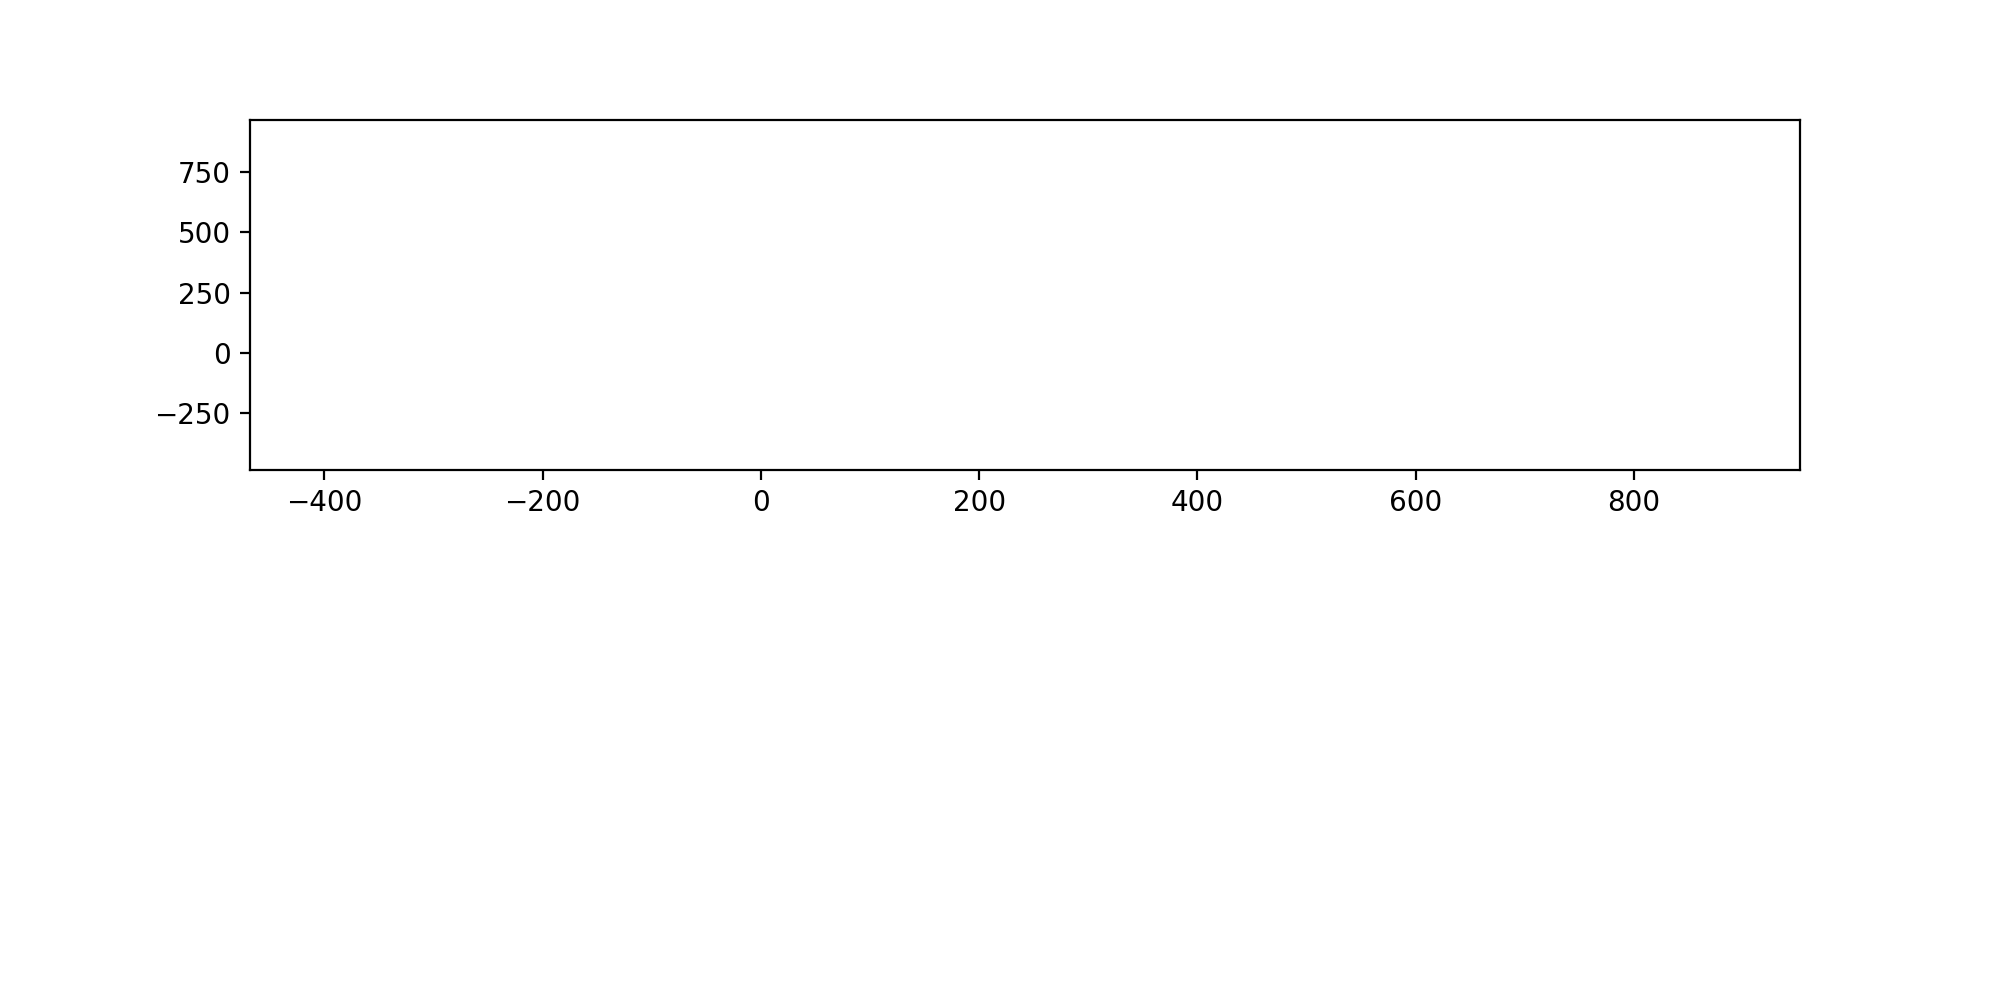

In [56]:
animate_scatterplot_distance(arg, val)

<IPython.core.display.Javascript object>


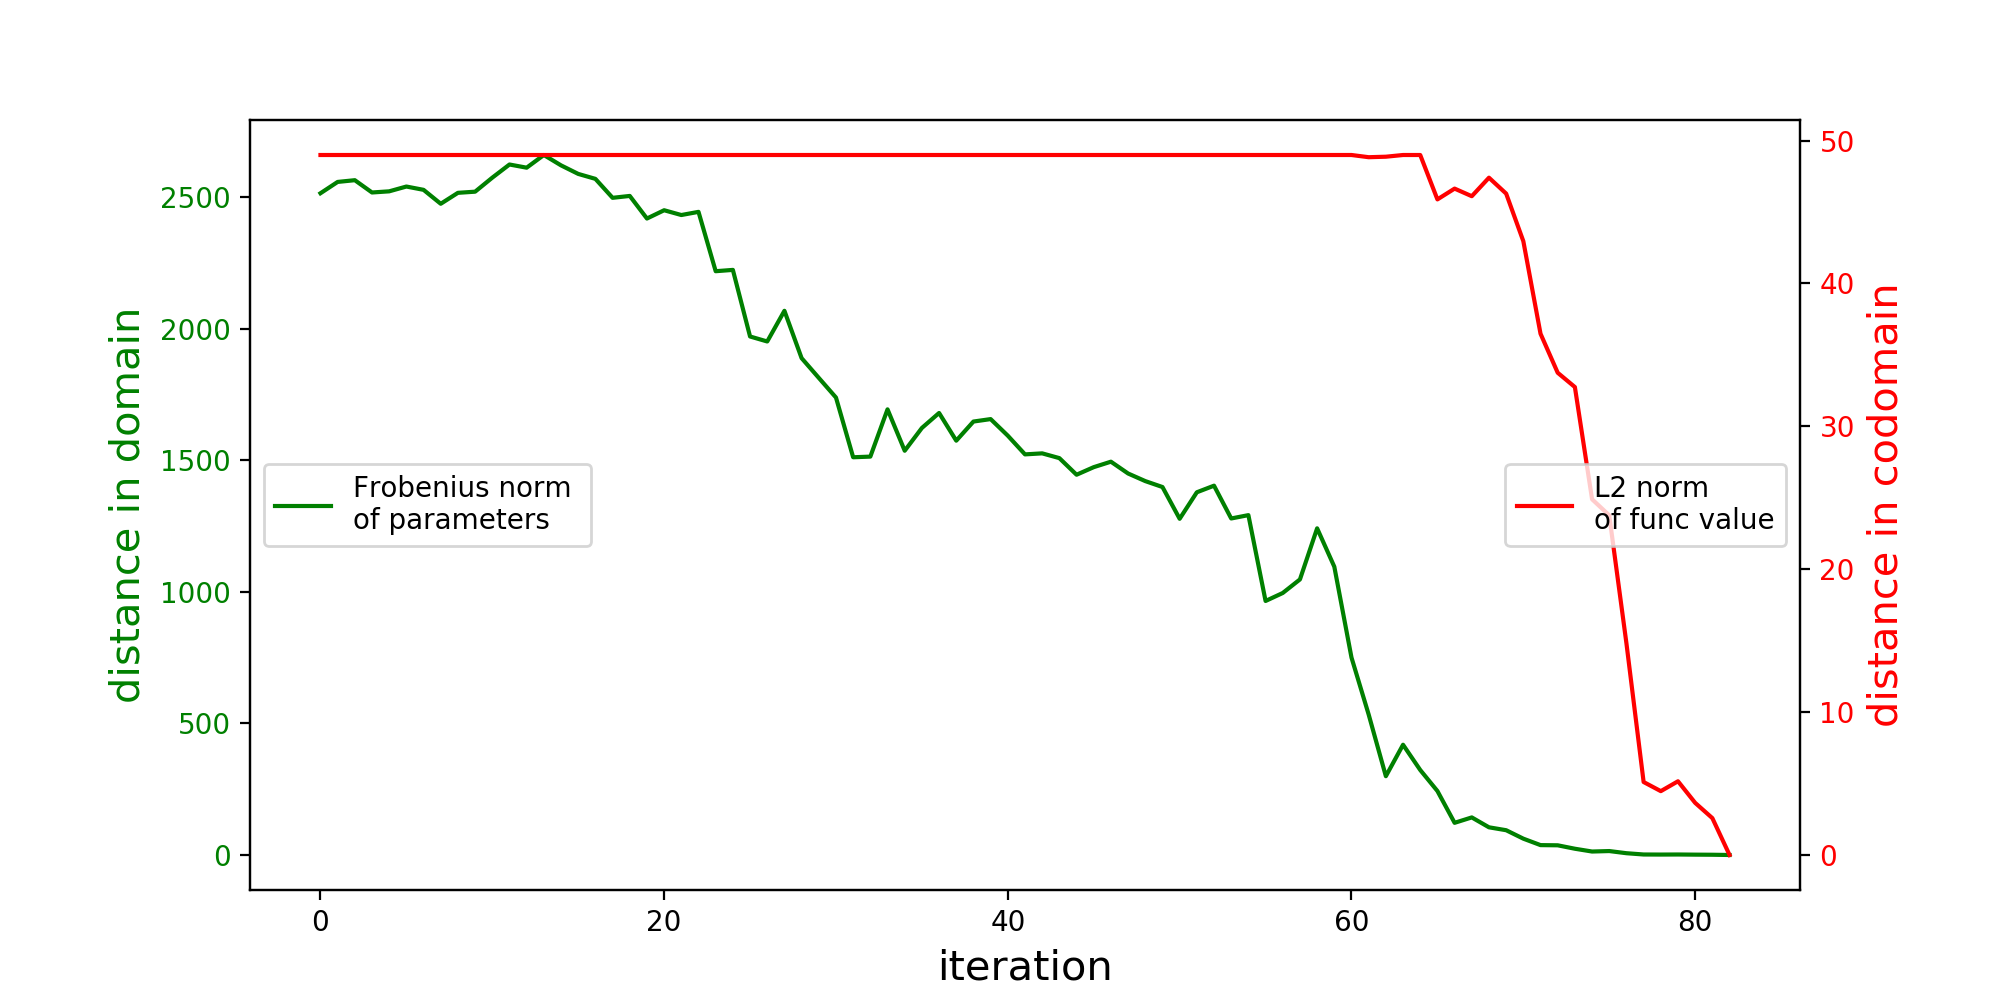

In [57]:
plot_distance(arg,val)

In [58]:
print_mean_variance(stats)

iter= 0 mean= [[629.193 822.221]] 
 [[1600.000 0.000]
 [0.000 1600.000]] 

iter= 1 mean= [[645.538 796.079]] 
 [[1164.077 -106.409]
 [-106.409 1281.117]] 

iter= 2 mean= [[666.681 817.544]] 
 [[803.429 31.963]
 [31.963 777.194]] 

iter= 3 mean= [[635.172 807.741]] 
 [[788.342 71.537]
 [71.537 588.354]] 

iter= 4 mean= [[627.901 815.191]] 
 [[543.382 12.888]
 [12.888 366.912]] 

iter= 5 mean= [[609.373 826.526]] 
 [[648.535 -101.224]
 [-101.224 359.706]] 

iter= 6 mean= [[583.687 837.985]] 
 [[1307.472 -356.759]
 [-356.759 536.996]] 

iter= 7 mean= [[578.958 829.177]] 
 [[1137.050 -260.900]
 [-260.900 427.482]] 

iter= 8 mean= [[584.783 839.015]] 
 [[694.193 -159.962]
 [-159.962 287.948]] 

iter= 9 mean= [[579.207 859.717]] 
 [[829.552 -251.792]
 [-251.792 576.824]] 

iter= 10 mean= [[536.372 886.913]] 
 [[4542.914 -1268.797]
 [-1268.797 2099.879]] 

iter= 11 mean= [[572.524 883.815]] 
 [[4504.496 -1185.035]
 [-1185.035 2030.508]] 

iter= 12 mean= [[594.466 873.165]] 
 [[2707.306 -708.9

In [314]:
np.random.seed(34)
mean0 = np.array([[629.193], [822.221]])
sigma = np.ones((2,)) * 40
alpha = 1
beta = 2

%time val, arg, stats = cma_es_general(mean0, sigma, alpha, beta, round_off)

stuck in local minimum or diverge!!
iterations = 200, eigenvalue = [0.137 5.674]
min = 20.0, total iterations = 200, total evaluatios = 1200
 position = 886.0 -12797.0

CPU times: user 95.6 ms, sys: 2.85 ms, total: 98.4 ms
Wall time: 98.8 ms


In [133]:
print(line_search(np.array([1.805, 0.525]), alpha, beta))
print(line_search(np.array([-1.805, 0.525]), alpha, beta))
print(line_search(np.array([1.805, -0.525]), alpha, beta))
print(line_search(np.array([-1.805, -0.525]), alpha, beta))
print(line_search(np.array([0.525, 1.805]), alpha, beta))

(array([1.959, 0.000]), 69)
(array([-1.959, 0.000]), 69)
(array([1.959, -0.000]), 69)
(array([-1.959, -0.000]), 69)
(array([0.000, 1.959]), 69)


In [6]:
def random_intial_mean(radius):
    rx = np.random.rand() * radius
    ry = np.random.rand() * rx 
    return np.array([rx, ry])

In [11]:


np.random.seed(61)
sigma = np.ones((2,)) * 40
alpha = 1
beta = 2
num = 100
radius = 1000
res = np.zeros((num,))
points = np.zeros((num,2))
result_strings = []
for i in range(num):
    points[i] = random_intial_mean(radius)
    val, arg, stats = cma_es_general(points[i].reshape(2,1), sigma, alpha, beta, round_off)
    if(len(val)!=200):
        res[i] = 1
    else:
        res[i] = 0
    

 


stuck in local minimum or diverge!!
iterations = 200, eigenvalue = [0.084 2.486]
min = 20.0, total iterations = 200, total evaluatios = 1200
 position = 2034.0 -45873.0

Global minimum
min = 4.440892098500626e-16, total iterations = 81, total evaluatios = 486
 position = 0.0 0.0

stuck in local minimum or diverge!!
iterations = 200, eigenvalue = [9.289 0.733]
min = 20.0, total iterations = 200, total evaluatios = 1200
 position = -754972.0 -74225.0

Global minimum
min = 4.440892098500626e-16, total iterations = 147, total evaluatios = 882
 position = -0.0 -0.0

Global minimum
min = 4.440892098500626e-16, total iterations = 200, total evaluatios = 1200
 position = -0.0 0.0

stuck in local minimum or diverge!!
iterations = 200, eigenvalue = [0.594 4.224]
min = 20.0, total iterations = 200, total evaluatios = 1200
 position = 760.0 266.0

Global minimum
min = 4.440892098500626e-16, total iterations = 31, total evaluatios = 186
 position = 0.0 -0.0

stuck in local minimum or diverge!!
iter

Global minimum
min = 4.440892098500626e-16, total iterations = 67, total evaluatios = 402
 position = 0.0 0.0

stuck in local minimum or diverge!!
iterations = 200, eigenvalue = [0.001 0.000]
min = 20.0, total iterations = 200, total evaluatios = 1200
 position = 493.0 467.0

Global minimum
min = 4.440892098500626e-16, total iterations = 107, total evaluatios = 642
 position = 0.0 0.0

stuck in local minimum or diverge!!
iterations = 200, eigenvalue = [1.643 0.843]
min = 20.0, total iterations = 200, total evaluatios = 1200
 position = 382.0 264.0

Global minimum
min = 4.440892098500626e-16, total iterations = 28, total evaluatios = 168
 position = 0.0 -0.0

stuck in local minimum or diverge!!
iterations = 200, eigenvalue = [0.003 0.000]
min = 20.0, total iterations = 200, total evaluatios = 1200
 position = 604.0 374.0

Global minimum
min = 4.440892098500626e-16, total iterations = 27, total evaluatios = 162
 position = -0.0 -0.0

stuck in local minimum or diverge!!
iterations = 200, 

<IPython.core.display.Javascript object>


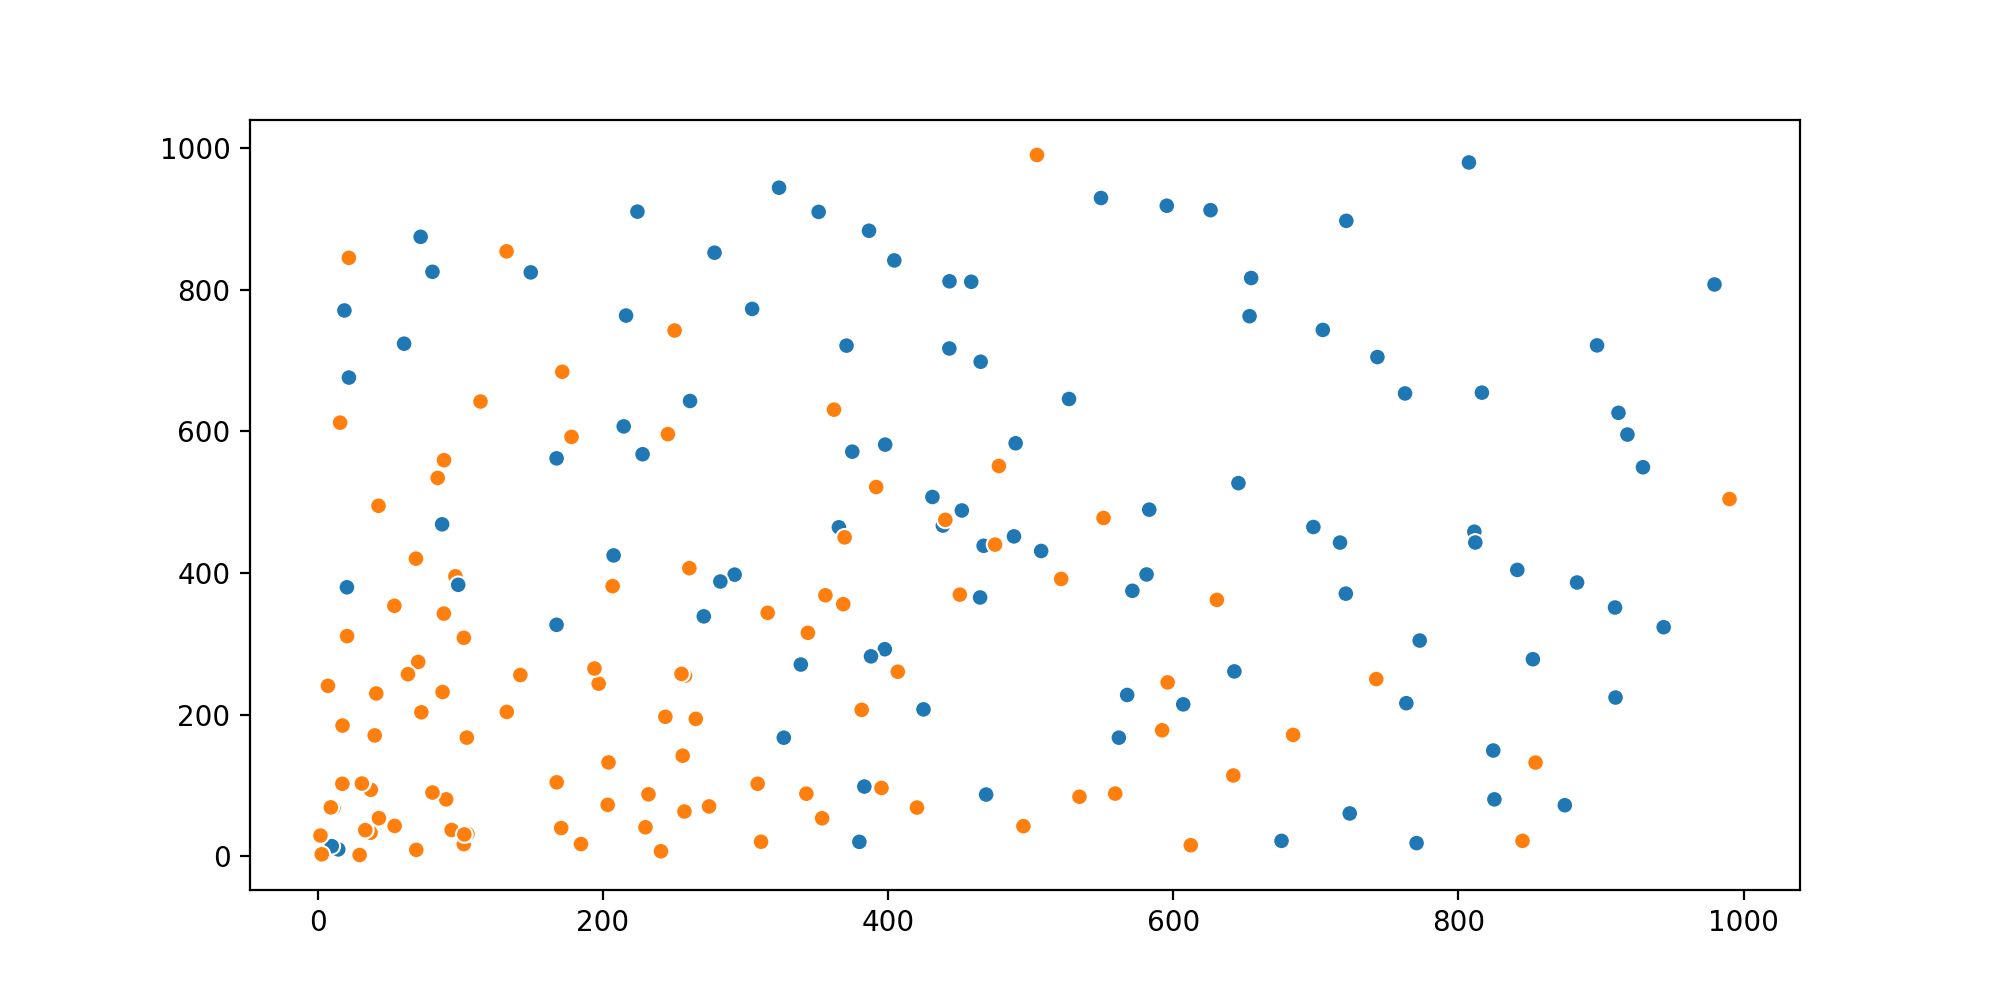

In [13]:
fig = plt.figure(figsize=(10,5))
p = sns.scatterplot(x=np.hstack((points[:,0], points[:,1])), y=np.hstack((points[:,1], points[:,0])), 
                    color="r", hue=np.hstack((res, res)), hue_norm=(0, 1), legend=False)

